# **Colab Environment Setup**

In [50]:
# Clone Lab 2's github repository to get all of our material first

!git clone https://github.com/yyyynwa/DM2025-Lab2-Exercise.git

fatal: destination path 'DM2025-Lab2-Exercise' already exists and is not an empty directory.


In [1]:
# Installing all of our dependencies
# The lab in colab was tested with this, and everything should work as intended
# If in your case something is not working please notify the TAs
!pip3 install python-dotenv==1.1.1 google-genai==1.33.0 langextract==1.0.9 langchain==0.3.27 langchain_community==0.3.29 langchain_core==0.3.75 langchain-google-genai==2.1.10 beautifulsoup4==4.13.5 chromadb==1.0.20 gradio==5.44.1 jupyter==1.1.1 scikit-learn==1.7.1 pandas==2.3.2 numpy==1.26.4 matplotlib==3.10.6 plotly==6.3.0 seaborn==0.13.2 nltk==3.9.1 umap-learn==0.5.9.post2 pymupdf==1.26.4

In [ ]:
# test code for environment setup
# import library
import dotenv
from google import genai
import langextract
import langchain
from langchain_community import utils
from langchain_core import prompts
from langchain_google_genai import chat_models
from bs4 import BeautifulSoup
import chromadb
import gradio
import jupyter
import sklearn
import pandas
import numpy
import matplotlib
import plotly
import seaborn
import nltk
import umap
import pymupdf

%matplotlib inline

##### **OPTIONAL: If you want to save your outputs you can send them to your own drive by mounting the drive in the following way (uncomment the lines):**

In [ ]:

# Remember to change the directory of your outputs to your folder in the new mounted google drive inside colab
# from google.colab import drive
# drive.mount('/content/drive/')


**Table of contents**<a id='toc0_'></a>    
- [Data Mining Lab 2 - Phase 2](#toc1_)    
  - [Before Starting](#toc1_1_)    
  - [Introduction](#toc1_2_)    
  - [**1. Data Preparation**](#toc1_3_)    
  - [**1.1 Load data**](#toc1_4_)    
    - [**1.2 Save data**](#toc1_4_1_)    
  - [**2. Large Language Models (LLMs)**](#toc1_5_)    
    - [Open-Source vs. Proprietary LLMs](#toc1_5_1_)    
    - [Why Use Code (API) for Data Mining?](#toc1_5_2_)    
    - [The Gemini API](#toc1_5_3_)    
    - [Interacting with the Gemini API](#toc1_5_4_)    
    - [**2.1 Text Prompting**](#toc1_5_5_)    
        - [**>>> Exercise 1 (Take home):**](#toc1_5_5_1_1_)    
    - [**2.2 Structured Output**](#toc1_5_6_)    
        - [**>>> Exercise 2 (Take home):**](#toc1_5_6_1_1_)    
    - [**2.3 Information Extraction and Grounding:**](#toc1_5_7_)    
      - [**`langextract`: A Library for Grounded Extraction**](#toc1_5_7_1_)    
        - [**2.3.1 Using PDF Documents:**](#toc1_5_7_1_1_)    
        - [**>>> Bonus Exercise 3 (Take home):**](#toc1_5_7_1_2_)    
    - [**2.4 Generating LLM Embeddings:**](#toc1_5_8_)    
        - [**>>> Exercise 4 (Take home):**](#toc1_5_8_1_1_)    
    - [**2.5 Retrieval-Augmented Generation (RAG)**](#toc1_5_9_)    
        - [**Actual answer in the URL:**](#toc1_5_9_1_1_)    
        - [**Content in the URL that might get into the generated answer because of similar semantic meaning:**](#toc1_5_9_1_2_)    
        - [**>>> Bonus Exercise 5 (Take home):**](#toc1_5_9_1_3_)    
    - [**2.6 Few-Shot Prompting Classification:**](#toc1_5_10_)    
        - [**>>> Exercise 6 (Take home):**](#toc1_5_10_1_1_)    
        - [**>>> Exercise 7 (Take home):**](#toc1_5_10_1_2_)    
    - [**2.7 Extra LLM Related Materials:**](#toc1_5_11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# Data Mining Lab 2 - Phase 2
In this lab's phase 2 session we will focus on exploring some basic LLMs' applications with data.


## Before Starting

**Make sure you have installed all the required libraries and you have the environment ready to run this lab.**
    

---
## Introduction

**Dataset:** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

**Task:** Classify text data into 4 different emotions using word embeddings and other deep information retrieval approaches.

![pic0.png](https://drive.google.com/uc?export=view&id=1qurztXdx30Wl2vkCZg7KXXJYJXcE6YR_)

---
## **1. Data Preparation**

---
## **1.1 Load data**

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [2]:
import pandas as pd

### training data
anger_train = pd.read_csv("./DM2025-Lab2-Exercise/data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("./DM2025-Lab2-Exercise/data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("./DM2025-Lab2-Exercise/data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("./DM2025-Lab2-Exercise/data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [3]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [4]:
### testing data
anger_test = pd.read_csv("./DM2025-Lab2-Exercise/data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("./DM2025-Lab2-Exercise/data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("./DM2025-Lab2-Exercise/data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("./DM2025-Lab2-Exercise/data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [5]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [7]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### **1.2 Save data**

In [8]:
# save to pickle file
train_df.to_pickle("./DM2025-Lab2-Exercise/data/train_df.pkl")
test_df.to_pickle("./DM2025-Lab2-Exercise/data/test_df.pkl")

In [9]:
import pandas as pd

# load a pickle file
train_df = pd.read_pickle("./DM2025-Lab2-Exercise/data/train_df.pkl")
test_df = pd.read_pickle("./DM2025-Lab2-Exercise/data/test_df.pkl")

For more information: https://reurl.cc/0Dzqx

---
## **2. Large Language Models (LLMs)**

Before we start we strongly suggest that you watch the following video explanations so you can understand the concepts that we are gonna discuss about LLMs:

1. [How Large Language Models Work](https://www.youtube.com/watch?v=5sLYAQS9sWQ)
2. [Large Language Models explained briefly](https://www.youtube.com/watch?v=LPZh9BOjkQs)
3. [What is Prompt Tuning?](https://www.youtube.com/watch?v=yu27PWzJI_Y)
4. [Why Large Language Models Hallucinate](https://www.youtube.com/watch?v=cfqtFvWOfg0)
5. [What are LLM Embeddings?](https://www.youtube.com/watch?v=UShw_1NbpCw&t=182s)
6. [What is Retrieval-Augmented Generation (RAG)?](https://www.youtube.com/watch?v=T-D1OfcDW1M)
7. [RAG vs Fine-Tuning vs Prompt Engineering: Optimizing AI Models](https://www.youtube.com/watch?v=zYGDpG-pTho)
8. [Discover Few-Shot Prompting | Google AI Essentials](https://www.youtube.com/watch?v=9qdgEBVkWR4)
9. [What is Zero-Shot Learning?](https://www.youtube.com/watch?v=pVpr4GYLzAo)
10. [Zero-shot, One-shot and Few-shot Prompting Explained | Prompt Engineering 101](https://www.youtube.com/watch?v=sW5xoicq5TY)

`These videos can help you get a better grasp on the core concepts of LLMs if you were not familiar before.`

**So now let's start with the main content of Lab 2 Phase 2.**

Large Language Models (LLMs) are AI systems trained on vast amounts of text to understand and generate human language for tasks like summarization and translation.

### Open-Source vs. Proprietary LLMs
*   **Open-Source Models** (e.g., Llama, Gemma) are customizable and cost-effective but require technical skill to manage and may be less powerful.
*   **Proprietary Models** (e.g., Gemini, ChatGPT) offer top performance and ease of use but are more costly and less flexible.

For students interested in running models locally, the optional notebook `DM2025-Lab2-Optional-Ollama.ipynb` explores using Ollama ([Ollama GitHub Link](https://github.com/ollama/ollama)). It needs a capable GPU to run models (**at least 4GB VRAM**).

You can explore the variety of models available through Ollama here:

![pic10.png](https://drive.google.com/uc?export=view&id=1ZvD7_yeSCETl98vXI5zo_TikF6Wpu0-r)

### Why Use Code (API) for Data Mining?

For data analysis, accessing LLMs programmatically is superior to using web chatbots because it allows for:
*   **Automation:** Easily process entire datasets with loops.
*   **Structured Output:** Receive data in usable formats like **JSON**, ready for analysis in tools like pandas.
*   **Reproducibility:** Ensure consistent results by setting fixed parameters.
*   **Privacy:** Maintain data security, especially when running models locally.

For the main exercises in this lab, we will use **the Gemini API**. This approach offers several advantages over running local open-source models, such as access to state-of-the-art model performance without needing specialized hardware. While the API has usage limits (rate limits and token quotas), it provides a generous **free tier** that is more than sufficient for our exercises.

![pic13.png](https://drive.google.com/uc?export=view&id=1UGHgSyH2-m2ZdjJXJ39_8RCgZov2z94d)

![pic14.png](https://drive.google.com/uc?export=view&id=1D0Q5KpS5bNIH8er0kb8SWt1nZJhfufWa)

### The Gemini API

We will primarily use the **Gemini 2.5 Flash-Lite** (`gemini-2.5-flash-lite`) model. As shown in the rate limit table, this model is optimized for high-frequency tasks and offers a high request-per-day limit of 1,000, making it ideal for completing the lab exercises without interruption.

Students are encouraged to explore other models available through the API but should remain mindful of their respective usage limits. For instance:
*   **Gemini 2.5 Pro** is a more powerful model but has a lower daily request limit of 100.
*   The **Gemma 3** model available via the API offers an impressive 14,400 requests per day, providing another excellent alternative for experimentation.

Please be aware of your usage limits as you work through the exercises to ensure you do not get rate-limited.

[Gemini Documentation](https://ai.google.dev/gemini-api/docs)

[Gemini Rate Limits](https://ai.google.dev/gemini-api/docs/rate-limits)

[Description of Gemini Models](https://ai.google.dev/gemini-api/docs/models)

---

### Interacting with the Gemini API

The code cell below contains the primary function, `prompt_gemini`, that we will use throughout this lab to communicate with the Gemini API. It's designed to be a flexible wrapper that handles the details of sending a request and receiving a response.

Before you run the exercises, here are the key things you need to understand in this setup:

*   **API Key Configuration**: The script loads your API key from a `.env` file located in the `./config/` directory. **You must create this file and add your API key** like this: `GOOGLE_API_KEY='YOUR_API_KEY_HERE'`. This is a security best practice to keep your credentials out of the code.

*   **Global Settings**: At the top of the script, you can find and modify several important defaults:
    *   `MODEL_NAME`: We've set this to `"gemini-2.5-flash-lite"`, but you can easily switch to other models like `"gemini-2.5-pro"` to experiment.
    *   `SYSTEM_INSTRUCTION`: This sets the model's default behavior or persona (e.g., "You are a helpful assistant"). You can customize this for different tasks.
    *   `SAFETY_SETTINGS`: For our academic exercises, these are turned off to prevent interference. In real-world applications, you would configure these carefully.

*   **The `prompt_gemini` function**: This is the main tool you will use. Here are its most important parameters:
    *   `input_prompt`: The list of contents (text, images, etc.) you want to send to the model.
    *   `temperature`: Controls the randomness of the output. `0.0` makes the output deterministic and less creative, while a higher value (e.g., `0.7`) makes it more varied.
    *   `schema`: A powerful feature that allows you to specify a JSON format for the model's output. This is extremely useful for structured data extraction.
    *   `with_tokens_info`: If set to `True`, the function will also return the number of input and output tokens used, which is helpful for monitoring your usage against the free tier limits.

In the following exercises, you will call this function with different prompts and configurations to solve various tasks.

If needed, you can also check some tutorials on how a python function works: [Python Functions Tutorial](https://realpython.com/defining-your-own-python-function/)

In [52]:
import os
from google.colab import userdata
from google import genai
from google.genai import types


# System instruction that can dictate how the model behaves in the output, can be customized as needed
SYSTEM_INSTRUCTION = (
        "You are a helpful assistant"
    )

# Max amount of tokens that the model can output, the Gemini 2.5 Models have this maximum amount
# For other models need to check their documentation
MAX_OUTPUT_TOKENS = 65535
MODEL_NAME = "gemini-2.5-flash-lite" # Other models: "gemini-2.5-pro", "gemini-2.5-flash"; Check different max output tokens: "gemini-2.0-flash" , "gemini-2.0-flash-lite"

# We disable the safety settings, as no moderation is needed in our tasks
SAFETY_SETTINGS = [
    types.SafetySetting(
        category="HARM_CATEGORY_HATE_SPEECH", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_SEXUALLY_EXPLICIT", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_HARASSMENT", threshold="OFF")
]

# We input the API Key to be able to use the Gemini models
api_key = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = api_key
client = genai.Client(api_key=api_key)

# We also set LangExtract to use the API key as well:
if 'GEMINI_API_KEY' not in os.environ:
    os.environ['GEMINI_API_KEY'] = api_key

def prompt_gemini(
        input_prompt: list,
        schema = None,
        temperature: float = 0.0,
        system_instruction: str = SYSTEM_INSTRUCTION,
        max_output_tokens: int = MAX_OUTPUT_TOKENS,
        client: genai.Client = client,
        model_name: str = MODEL_NAME,
        new_config: types.GenerateContentConfig = None,
        with_tools: bool = False,
        with_parts: bool = False,
        with_tokens_info: bool = False
    ):
        try:
            # If we need a JSON schema we set up the following
            if schema:
                generate_content_config = types.GenerateContentConfig(
                    temperature=temperature,
                    system_instruction=system_instruction,
                    max_output_tokens=max_output_tokens,
                    response_modalities=["TEXT"],
                    response_mime_type="application/json",
                    response_schema=schema,
                    safety_settings=SAFETY_SETTINGS
                )
            # If there is no need we leave it unstructured
            else:
                generate_content_config = types.GenerateContentConfig(
                    temperature=temperature,
                    system_instruction=system_instruction,
                    max_output_tokens=max_output_tokens,
                    response_modalities=["TEXT"],
                    safety_settings=SAFETY_SETTINGS
                )

            # We add a different custom configuration if we need it
            if new_config:
                generate_content_config = new_config

            # For some tasks we need a more specific way to add the contents when prompting the model
            # So we need custom parts for it sometimes from the "types" objects
            if with_parts:
                response = client.models.generate_content(
                    model=model_name,
                    contents=types.Content(parts=input_prompt),
                    config=generate_content_config,
                )
            # In the simplest form the contents can be expressed as a list [] of simple objects like str and Pillow images
            else:
                response = client.models.generate_content(
                    model=model_name,
                    contents=input_prompt,
                    config=generate_content_config,
                )

            if with_tools:
                # print(response)
                # Include raw response when function calling
                completion = response
                if with_tokens_info:
                    log = {
                        "model": model_name,
                        "input_tokens": response.usage_metadata.prompt_token_count,
                        "output_tokens": response.usage_metadata.candidates_token_count,
                    }
                    return completion, log
                return completion
            else:
                completion = response.text
                if with_tokens_info:
                    log = {
                        "model": model_name,
                        "input_tokens": response.usage_metadata.prompt_token_count,
                        "output_tokens": response.usage_metadata.candidates_token_count,
                    }
                    # Return the text response and logs (if selected)
                    return completion, log
                return completion
        except Exception as e:
             print(f"Error occurred when generating response, error: {e}")
             return None

---
### **2.1 Text Prompting**

In the same way as with ChatGPT we can use the Gemini models to ask about anything. Here we are going to ask a question requesting the response to be in markdown format, this is to make it have a better display afterwards.

For more information visit:
[Gemini's Text Generation Documentation](https://ai.google.dev/gemini-api/docs/text-generation)

In [ ]:
input_prompt = ["What is Data Mining?"]
text_response, logs = prompt_gemini(input_prompt = input_prompt, with_tokens_info = True)
print(text_response)

Data mining is the process of **discovering patterns, insights, and knowledge from large datasets**. It's essentially about extracting valuable information that isn't immediately obvious from raw data. Think of it as sifting through a mountain of information to find hidden gems.

Here's a breakdown of what that means:

**Key Concepts:**

*   **Large Datasets:** Data mining is typically applied to datasets that are too large and complex for manual analysis. This can include customer transaction records, website logs, sensor data, social media feeds, scientific experiment results, and much more.
*   **Patterns and Insights:** The goal is to identify recurring trends, correlations, anomalies, and relationships within the data. These patterns can reveal underlying structures, predict future behavior, or explain observed phenomena.
*   **Knowledge Discovery:** The ultimate aim is to transform raw data into actionable knowledge that can be used for decision-making, problem-solving, and strat

We can also check the logs of the usage with our model that we defined in our previous function. We can observe the model we used, how many tokens where in the prompt in the input, and the output text response tokens of our model.

In [ ]:
print(logs)

{'model': 'gemini-2.5-flash-lite', 'input_tokens': 12, 'output_tokens': 911}


**We can use the IPython library to make the response look better:**

In [ ]:
from IPython.display import display, Markdown
display(Markdown(text_response))

Data mining is the process of **discovering patterns, insights, and knowledge from large datasets**. It's essentially about extracting valuable information that isn't immediately obvious from raw data. Think of it as sifting through a mountain of information to find hidden gems.

Here's a breakdown of what that means:

**Key Concepts:**

*   **Large Datasets:** Data mining is typically applied to datasets that are too large and complex for manual analysis. This can include customer transaction records, website logs, sensor data, social media feeds, scientific experiment results, and much more.
*   **Patterns and Insights:** The goal is to identify recurring trends, correlations, anomalies, and relationships within the data. These patterns can reveal underlying structures, predict future behavior, or explain observed phenomena.
*   **Knowledge Discovery:** The ultimate aim is to transform raw data into actionable knowledge that can be used for decision-making, problem-solving, and strategic planning.

**How it Works (The Process):**

Data mining is usually an iterative process that involves several stages:

1.  **Business Understanding:** Defining the problem or objective you want to achieve with data mining. What questions are you trying to answer? What business goals are you trying to meet?
2.  **Data Understanding:** Exploring and getting familiar with the data. This involves collecting, cleaning, and understanding the data's structure, quality, and meaning.
3.  **Data Preparation (Preprocessing):** This is often the most time-consuming stage. It involves:
    *   **Cleaning:** Handling missing values, noisy data, and inconsistencies.
    *   **Integration:** Combining data from multiple sources.
    *   **Transformation:** Normalizing or aggregating data to make it suitable for mining.
    *   **Reduction:** Reducing the size of the dataset while preserving important information.
4.  **Modeling:** Selecting and applying appropriate data mining techniques (algorithms) to discover patterns. This is where the "mining" happens.
5.  **Evaluation:** Assessing the quality and usefulness of the discovered patterns. Do they make sense? Are they statistically significant? Do they meet the business objectives?
6.  **Deployment:** Putting the discovered knowledge into practice. This could involve integrating it into business processes, creating reports, or building predictive models.

**Common Data Mining Techniques:**

Data mining employs a variety of techniques, often drawing from statistics, machine learning, and database systems. Some of the most common include:

*   **Classification:** Categorizing data into predefined classes (e.g., predicting whether a customer will churn or not).
*   **Clustering:** Grouping similar data points together without predefined classes (e.g., segmenting customers into different groups based on their purchasing behavior).
*   **Association Rule Mining:** Discovering relationships between items in a dataset (e.g., "customers who buy bread also tend to buy milk"). This is often used in market basket analysis.
*   **Regression:** Predicting a continuous numerical value (e.g., predicting the price of a house based on its features).
*   **Anomaly Detection (Outlier Detection):** Identifying data points that deviate significantly from the norm (e.g., detecting fraudulent transactions).
*   **Sequential Pattern Mining:** Discovering patterns that occur in a sequence over time (e.g., identifying common user navigation paths on a website).

**Why is Data Mining Important?**

Data mining is crucial for businesses and organizations because it enables them to:

*   **Make Better Decisions:** By understanding customer behavior, market trends, and operational efficiencies, organizations can make more informed and strategic decisions.
*   **Improve Customer Relationships:** Identifying customer preferences and predicting their needs allows for personalized marketing, better customer service, and increased loyalty.
*   **Detect Fraud and Risk:** Anomaly detection can help identify fraudulent activities, security breaches, and potential risks.
*   **Optimize Operations:** Understanding patterns in operational data can lead to improved efficiency, reduced costs, and better resource allocation.
*   **Drive Innovation:** Discovering new insights can spark new product development, service offerings, and business models.
*   **Gain a Competitive Advantage:** Organizations that effectively leverage data mining can outperform their competitors by understanding their market and customers better.

In essence, data mining is a powerful tool for transforming raw data into valuable intelligence, driving progress and innovation across various fields.

---
##### **>>> Exercise 1 (Take home):**

`With your own prompt`, run the previous example in the following way:

1. Run it with the same model as the example (gemini-2.5-flash-lite).
2. Run it with a different gemini model from the available options for the API.
3. Discuss the differences on the results with different models.
4. Discuss what would happen if you change the system prompt.


In [ ]:
# Answer here
from IPython.display import display, Markdown

MODEL_NAME = "gemini-2.5-flash-lite"

input_prompt_ex1 = ["How much do you know about Diffusion-scheduled Denoising AutoEncoder (DDAE)?"]

print("\nModel: gemini-2.5-flash-lite")
response, logs = prompt_gemini(input_prompt = input_prompt_ex1, with_tokens_info = True)
display(Markdown(response))

print("\nModel: gemini-2.5-flash")
MODEL_NAME_ex1 = "gemini-2.5-flash"
response_pro, logs = prompt_gemini(input_prompt = input_prompt_ex1, model_name = MODEL_NAME_ex1, with_tokens_info = True)
display(Markdown(response_pro))



Model: gemini-2.5-flash-lite


I have a good understanding of Diffusion-scheduled Denoising Autoencoders (DDAE). Here's a breakdown of what I know:

**Core Concept:**

DDAE is a type of generative model that combines the strengths of **Denoising Autoencoders (DAEs)** and **Diffusion Models**. The key idea is to leverage the efficient learning of DAEs for reconstructing clean data from noisy versions, while incorporating the powerful generative capabilities of diffusion models.

**How it Works (General Principles):**

1.  **Denoising Autoencoder Foundation:** At its heart, a DAE is trained to take a corrupted (noisy) input and reconstruct the original, clean input. This is achieved by adding noise to the data during training and then training an encoder-decoder network to "denoise" it.

2.  **Diffusion Process Integration:** Diffusion models work by gradually adding noise to data over a series of timesteps (forward diffusion process) until it becomes pure noise. Then, a generative model (often a neural network) is trained to reverse this process, gradually removing noise to generate new data (reverse diffusion process).

3.  **The "Diffusion-Scheduled" Aspect:** This is where DDAE distinguishes itself. Instead of a single denoising step like a traditional DAE, DDAE uses a **scheduled sequence of denoising steps**, inspired by the diffusion process. This means the model doesn't just denoise once; it performs multiple denoising operations, each targeting a different level of noise.

**Key Components and Mechanisms:**

*   **Noise Schedule:** Similar to diffusion models, DDAE employs a noise schedule that defines how much noise is added at each step of the forward process. This schedule dictates the difficulty of the denoising task at each stage.
*   **Denoising Network:** A neural network (often a U-Net architecture, common in diffusion models) is trained to perform the denoising at each timestep. This network learns to predict the noise that was added or the clean data itself.
*   **Timestep Conditioning:** The denoising network is conditioned on the current timestep. This allows it to learn how to denoise effectively at different noise levels.
*   **Training Objective:** The training objective typically involves minimizing the difference between the model's output and the true clean data at various noise levels, guided by the diffusion schedule. This can involve predicting the noise added or directly predicting the denoised sample.

**Advantages of DDAE:**

*   **Improved Generative Quality:** By mimicking the multi-step denoising of diffusion models, DDAEs can often achieve higher quality and more realistic generated samples compared to standard DAEs.
*   **Computational Efficiency (Potentially):** Compared to some pure diffusion models that require many sampling steps, DDAEs can sometimes be more efficient during inference if the number of denoising steps is reduced.
*   **Leveraging DAE Strengths:** They benefit from the efficient learning capabilities of DAEs for reconstruction tasks.
*   **Flexibility:** The diffusion schedule can be adapted to control the trade-off between generation quality and computational cost.

**Relationship to Other Models:**

*   **Denoising Autoencoders (DAEs):** DDAE is a direct extension of DAEs, incorporating the multi-step denoising idea from diffusion.
*   **Diffusion Models (DDPMs, Score-based models):** DDAE borrows the core concept of a gradual denoising process from diffusion models. However, it might use a different network architecture or training objective than traditional diffusion models.
*   **Variational Autoencoders (VAEs):** While both are generative models, VAEs focus on learning a latent space distribution, whereas DDAEs focus on the denoising process.

**Potential Applications:**

*   **Image Generation:** Creating realistic and diverse images.
*   **Image Inpainting/Editing:** Filling in missing parts of images or modifying existing ones.
*   **Super-resolution:** Enhancing the resolution of low-resolution images.
*   **Audio Generation:** Synthesizing realistic audio.
*   **Other Data Generation Tasks:** Applicable to any data modality where denoising and generative capabilities are beneficial.

**Challenges and Considerations:**

*   **Hyperparameter Tuning:** The noise schedule, network architecture, and training parameters can be sensitive and require careful tuning.
*   **Computational Cost:** While potentially more efficient than some diffusion models, training and inference can still be computationally intensive.
*   **Understanding the "Schedule":** The specific implementation of the diffusion schedule can vary, and understanding its impact on generation is crucial.

**In summary, Diffusion-scheduled Denoising Autoencoders (DDAE) are a powerful class of generative models that bridge the gap between Denoising Autoencoders and Diffusion Models. They achieve impressive generative results by applying a sequence of denoising steps, guided by a diffusion-inspired schedule, to progressively refine noisy data into high-quality outputs.**

If you have any specific questions about DDAE, such as its architecture, training details, or comparisons to other models, feel free to ask! I'm happy to delve deeper.


Model: gemini-2.5-flash


The term "Diffusion-scheduled Denoising AutoEncoder (DDAE)" isn't a widely established, distinct model architecture in the same way that "DDPM" or "Stable Diffusion" are. Instead, it's a very insightful way of **conceptualizing and understanding the core mechanism of many modern diffusion models**, particularly Denoising Diffusion Probabilistic Models (DDPMs).

Here's a breakdown of what it means and why it's a powerful perspective:

### The Core Idea: Diffusion Models as Iterative, Scheduled Denoising Autoencoders

At its heart, a DDAE perspective views a diffusion model as a **single denoising autoencoder (DAE) that is trained to perform denoising at various noise levels (or "time steps") and then applied iteratively in a scheduled manner to generate data.**

Let's break down the components:

1.  **Denoising AutoEncoder (DAE):**
    *   A standard DAE is a neural network (often an autoencoder-like architecture, like a U-Net) that takes a noisy input and tries to reconstruct the original, clean input.
    *   Its objective is to learn to remove noise.

2.  **Diffusion-scheduled:**
    *   This is the crucial part. In a diffusion model, the noise isn't just random noise; it's noise added according to a **predefined "diffusion schedule"** (or noise schedule). This schedule dictates how much noise is added at each "time step" $t$, gradually transforming a clean image $x_0$ into pure Gaussian noise $x_T$ over $T$ steps.
    *   The DAE is trained to denoise inputs *at any of these scheduled noise levels*. This means the DAE must be **conditioned on the current time step $t$** (or the corresponding noise level). This conditioning allows the DAE to know *how much* noise it's supposed to be removing.

### How it Works (Training and Inference):

#### 1. Training the DDAE:

*   **Input:** A clean data sample $x_0$ (e.g., an image).
*   **Noise Addition:** A random time step $t$ is sampled from $1$ to $T$. Based on the diffusion schedule, a specific amount of Gaussian noise is added to $x_0$ to create a noisy version $x_t$.
*   **Denoising Task:** The DDAE (the neural network) takes $x_t$ and the time step $t$ as input. Its goal is to predict either:
    *   The original clean image $x_0$.
    *   The noise $\epsilon$ that was added to $x_0$ to get $x_t$.
    *   The score function (gradient of the log-density).
*   **Loss Function:** Typically, a Mean Squared Error (MSE) loss is used between the DDAE's prediction and the true target (e.g., predicted noise vs. actual noise).
*   **Result:** After training, the DDAE is a single network capable of denoising images corrupted by *any* level of noise specified by the diffusion schedule.

#### 2. Inference (Generating New Data) with the DDAE:

*   **Start with Noise:** Begin with pure Gaussian noise $x_T$ (representing an image at the final, most noisy time step).
*   **Iterative Denoising:** The trained DDAE is then applied iteratively, starting from $t=T$ down to $t=1$:
    *   At each step $t$, the DDAE takes the current noisy image $x_t$ and the time step $t$ as input.
    *   It predicts the noise (or $x_0$) for that step.
    *   Using this prediction and the diffusion schedule's equations (e.g., DDPM's reverse process equations or DDIM's sampling equations), a slightly less noisy image $x_{t-1}$ is computed.
*   **Final Output:** After $T$ steps, $x_0$ is obtained, which is a newly generated, clean data sample.

### Why this Perspective is Powerful:

1.  **Unification:** It elegantly unifies the concept of a simple denoising autoencoder with the complex probabilistic framework of diffusion models. It shows that the "magic" of diffusion models largely comes from the *iterative, scheduled application* of a DAE.
2.  **Simplicity:** It simplifies the understanding of diffusion models. Instead of thinking about complex stochastic differential equations or variational bounds, one can primarily think about training a robust denoiser.
3.  **Flexibility:** This perspective highlights that the core component is the denoiser. Improvements to DAE architectures (e.g., U-Nets, Transformers) directly translate to better diffusion models.
4.  **Foundation:** It underscores that the fundamental learning objective of many diffusion models is essentially a denoising task.

In essence, when you hear "Diffusion-scheduled Denoising AutoEncoder," think of it as a precise and descriptive way to refer to the neural network at the heart of most modern diffusion models, emphasizing its role as a denoiser trained across a spectrum of noise levels defined by a diffusion process.

1.   **Model Differences:**

| Difference\Model               | gemini-2.5-flash-lite                                                                                                                                                                                                                                           | gemini-2.5-flash                                                                                                                                                            |
|----------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Respond              | Details about "DDAE" were fabricated, as if it were a mature model. <br>Its explanations mostly resemble a hybrid of denoising autoencoders, <br>DDPM/scoring models, and timed denoising, using seemingly plausible <br>and comprehensive analyses to fill knowledge gaps. | Correctly recognized that “DDAE” is not a widely standardized term <br>and reframed the answer around the conceptual interpretation <br>(i.e., diffusion models as scheduled DAEs). |
| Behavior             | Tried to explain the phrase literally, and assuming it referred to a <br>known architecture, even if it had to invent some acceptable structure.                                                                                                                    | Understood the context of ML terminology and recognized <br>that "DDAE" is a conceptual framing rather than a typical standard model.                                           |
| Hallucinations       | More likely                                                                                                                                                                                                                                                     | Much less likely                                                                                                                                                            |
| Depth of explanation | Elaborates broadly, sometimes invents details                                                                                                                                                                                                                   | Deeper, more grounded                                                                                                                                                       |
| Awareness  | Rarely says “uncertain”                                                                                                                                                                                                                                   | Correctly flags uncommon terms                                                                                                                                     |
| Tone                 | Tutorial-like, verbose                                                                                                                                                                                                                                          | Analytical, concise                                                                                                                                                         |


2.   **System Prompt Impact:**

```
STSTEM_PROMPT = 'Pretend to be an expert ML researcher.'

# gemini-2.5-flash
# Will produce truly advanced machine learning explanations

# gemini-2.5-flash-lite
# Will attempt, but may "fake" deeper knowledge, increasing the risk of illusion.
```


System prompts can affect:

* Tone
* Pormatting
* Reasoning behavior
* Depth of technical explanation
* Security/ethical behavior (even if security features are disabled)
* Willingness to admit "I don't know"
* Lengthiness
* Creativity
* Style

---
### **2.2 Structured Output**

By default, an LLM responds with unstructured, free-form text. For data mining, this is often impractical, as we need data in a predictable format to load into tools like a pandas DataFrame for analysis. **Structured output** is a powerful feature that forces the model to return its response in a specific, machine-readable format, such as JSON.

The key to enabling this is to provide the model with a **response schema**. This schema acts as a strict template or blueprint that the model's output must conform to. Instead of generating a paragraph, the model will fill in the fields defined in your schema with the relevant information it extracts from the prompt.

In the following code, we define this schema using Python classes. Think of each class as defining a JSON object:
*   The **attributes** of the class (e.g., `topic_name`, `sub_title`) become the keys in the final JSON object.
*   The **type hints** for those attributes (e.g., `str`, `list`) tell the model what kind of data is expected for each key's value.

We can even nest these classes inside one another to create complex, hierarchical JSON structures. This allows us to precisely control the format of the output, transforming the LLM from a simple text generator into a reliable tool for automated and structured data extraction.

[Gemini's Structured Output Documentation](https://ai.google.dev/gemini-api/docs/structured-output)

For data validation of schemas Gemini API uses the Pydantic library, for more documentation on it you can check: [Pydantic](https://docs.pydantic.dev/latest/)

[JSON Format Documentation](https://docs.python.org/3/library/json.html)

In [ ]:
from pydantic import BaseModel

# We define our structure schema that Gemini should follow for the output response

# Subsections on the topics we query
class Subsection(BaseModel):
    sub_title: str
    sub_explanation: str

# The top-level structure for the entire topic analysis
class Topic(BaseModel):
    topic_name: str
    subsections: list[Subsection]

In [ ]:
input_prompt = ["Explain what are machine learning, data centers, llms and how do they relate to each other."]
text_response = prompt_gemini(input_prompt = input_prompt, schema = list[Topic])
print(text_response)

[
  {
    "topic_name": "Machine Learning",
    "subsections": [
      {
        "sub_title": "Definition",
        "sub_explanation": "Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention."
      },
      {
        "sub_title": "Types of Machine Learning",
        "sub_explanation": "Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties)."
      },
      {
        "sub_title": "Applications",
        "sub_explanation": "ML is used in a wide range of applications, such as image recognition, natural language processing, recommend

In [ ]:
import json

# Now the response can be parsed to a python object using the JSON dictionary structure loading
structured_resp = json.loads(text_response)
print(structured_resp)
print(type(structured_resp))

[{'topic_name': 'Machine Learning', 'subsections': [{'sub_title': 'Definition', 'sub_explanation': "Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention."}, {'sub_title': 'Types of Machine Learning', 'sub_explanation': 'Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties).'}, {'sub_title': 'Applications', 'sub_explanation': 'ML is used in a wide range of applications, such as image recognition, natural language processing, recommendation systems, fraud detection, and medical diagnosis.'}]}, {'topic_name': 'Data Centers', 'subs

In [ ]:
# So now we have an object that we can explore/use in a pythonic way for our purposes
for topic in structured_resp:
    print(topic["topic_name"], "\n")
    # We can access each subsection as well
    for subsection in topic["subsections"]:
        print("\t", subsection["sub_title"], "\n")
        print("\t\t", subsection["sub_explanation"], "\n")


Machine Learning 

	 Definition 

		 Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention. 

	 Types of Machine Learning 

		 Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties). 

	 Applications 

		 ML is used in a wide range of applications, such as image recognition, natural language processing, recommendation systems, fraud detection, and medical diagnosis. 

Data Centers 

	 Definition 

		 A data center is a dedicated physical facility that an organization uses to house its critical IT infrastructure, including servers

##### **>>> Exercise 2 (Take home):**

Try a prompt with your own schema structure, it needs to be completely different to the example. It should show an intuitive way to represent the text output of the model based on the prompt you chose. See the documentation for reference: https://ai.google.dev/gemini-api/docs/structured-output

In [ ]:
# Answer here

# Prompt: Systemically explain Diffusion-scheduled Denoising AutoEncoder(DDAE)'s architecure and mechanism
# Defined structure schema

# Specific components within a phase
class Mechanism(BaseModel):
    mechanism_name: str
    technical_functions: str
    role_in_system: str

# Major logical part of the system
class Architecure(BaseModel):
    section_title: str
    section_objective: str
    mechanism: list[Mechanism]

# Entire DDAE explanation
class System(BaseModel):
    system_name: str
    overview: str
    architecture: list[Architecure]

---
### **2.3 Information Extraction and Grounding:**

`NOTE: This whole section including the exercise is now considered a bonus section, not counted for the main grade.`

When using LLMs to extract structured data from text, two main challenges arise:

1.  **Trust:** LLMs can "hallucinate" or invent information. We need to ensure the extracted data is accurate and comes directly from the source text.
2.  **Scalability:** We need a reliable way to extract complex information consistently from thousands of large, messy documents.

The solution to these challenges is **grounding**—the process of linking every piece of extracted data back to its specific origin in the source document. This creates a verifiable audit trail, building trust in the output.

---
#### **`langextract`: A Library for Grounded Extraction**

**`langextract`** is an open-source Python library from Google designed to create trustworthy data extraction pipelines. It uses LLMs to convert unstructured text into structured data with a focus on reliability and traceability.

**Key Features:**

*   **Precise Grounding:** Its core feature. It maps every extracted item to its exact character position in the original text, allowing for easy verification.
*   **Reliable Structured Output:** Uses examples (few-shot prompting) to ensure the LLM's output consistently follows a predefined format.
*   **Adaptable & No Fine-Tuning:** Can be adapted to any domain (e.g., legal, medical) simply by changing the examples and instructions, without needing to retrain a model.
*   **Handles Long Documents:** Built to process lengthy texts that might exceed an LLM's standard context window.
*   **Flexible LLM Support:** It is model-agnostic and works with various LLMs like Gemini, OpenAI models, and even local open-source models through Ollama.

**`Github repository:`** [langextract](https://github.com/google/langextract)

---

##### **2.3.1 Using PDF Documents:**

For PDF Document information extraction we are going to use the `pymupdf` library. Documentation: [pymupdf](https://pymupdf.readthedocs.io/en/latest/)

And then we are going to pass it on to langextract to get insights on the document's content.

We can also process documents using Gemini, for more information you can check their documentation: [Document Understanding](https://ai.google.dev/gemini-api/docs/document-processing)

In [ ]:
import pymupdf
# Extract text from the PDF and format it for the prompt
# This is a review from the movie interstellar
pdf_path = "./DM2025-Lab2-Exercise/data/documents/doc_example_review_interstellar.pdf"
formatted_text = ""
try:
    doc = pymupdf.open(pdf_path)
    # In case the PDF documents have more than one page, in this example it only has one
    for i, page in enumerate(doc):
        text = page.get_text("text")
        # Format follows the prompt's requirement: **Page X** """document's text"""
        formatted_text += f'**Page {i + 1}**\n'
        formatted_text += f'"""\n{text.strip()}\n"""\n\n'
    doc.close()
    print(f"✓ Extracted text from '{pdf_path}'")
except Exception as e:
    print(f"Could not read PDF: {e}")
    formatted_text = "Error: Could not process PDF file."

✓ Extracted text from './DM2025-Lab2-Exercise/data/documents/doc_example_review_interstellar.pdf'


In [ ]:
print(formatted_text)

**Page 1**
"""
Dan Baldwin
Group 4
Auteur Review - Interstellar 
I believe Christopher Nolan: the director behind the 2014 sci-ﬁ/adventure cinematic ‘Interstellar,’ 
to be a very intellectual and imaginative inventive talent.  
His style in his previous ﬁlms sets characters in epic unique locations, with gargantuan issues to 
face, and artistically impresses the audience with how the characters solve their problems. For 
example, in Nolan’s 2010 ﬁlm ‘Inception,’ he tackles the idea of dreams, and sets his characters 
diving through dreams within dreams within even more dreams to complete their goals. Because 
this idea is so farfetched, and dreams are a subject in which science has made little factual 
discovery in, Nolan is free to use his creativity to present ideas such as landscapes folding in on 
themselves and corridors spinning, without seeming unrealistic. 
This brain-racking epic theme is once again evident in ‘Interstellar,’ as Nolan sets his characters 
during a second Ameri

We define our prompt and examples based on our required type of data, in this case we are going to do it having `movie reviews` in mind.

In [ ]:
import langextract as lx
import textwrap

# Defining the extraction prompt for "movie review" type of data
prompt = textwrap.dedent("""\
    Extract specific opinions and their impact on the audience from this movie review.
    Important: Use exact text verbatim from the input for extraction_text. Do not paraphrase.
    Extract entities in order of appearance with no overlapping text spans.

    Use the 'opinion_statement' class for direct judgments about film elements (like plot, score, or acting).
    - 'subject' should be the element being reviewed.
    - 'sentiment' should be Positive, Negative, or Neutral.
    - 'key_phrase' should be the core descriptive words.

    Use the 'audience_impact' class for phrases describing the effect on the viewer.
    - 'emotion_evoked' should be the feeling or reaction (e.g., stress, joy, confusion).
    - 'causal_element' is what part of the film caused the reaction.
    - 'target_audience' is who was affected (e.g., 'the audience', 'the reviewer').
    """)

# Providing high-quality examples to guide the model
# These examples show the model exactly how to differentiate between the two classes
examples = [
    # Example 1: Demonstrates a positive opinion on the plot and its direct impact on the reviewer
    lx.data.ExampleData(
        text="The film boasts a truly clever plot that kept me guessing until the very end.",
        extractions=[
            lx.data.Extraction(
                extraction_class="opinion_statement",
                extraction_text="a truly clever plot",
                attributes={
                    "subject": "The plot",
                    "sentiment": "Positive",
                    "key_phrase": "truly clever"
                }
            ),
            lx.data.Extraction(
                extraction_class="audience_impact",
                extraction_text="kept me guessing until the very end",
                attributes={
                    "emotion_evoked": ["engaged", "curious"],
                    "causal_element": "The plot",
                    "target_audience": "the reviewer"
                }
            ),
        ]
    ),
    # Example 2: Shows a negative opinion and a separate audience impact caused by the soundtrack
    lx.data.ExampleData(
        text="Unfortunately, the dialogue felt clunky and unnatural, and the jarring soundtrack made the audience jump.",
        extractions=[
            lx.data.Extraction(
                extraction_class="opinion_statement",
                extraction_text="the dialogue felt clunky and unnatural",
                attributes={
                    "subject": "The dialogue",
                    "sentiment": "Negative",
                    "key_phrase": "clunky and unnatural"
                }
            ),
            lx.data.Extraction(
                extraction_class="audience_impact",
                extraction_text="made the audience jump",
                attributes={
                    "emotion_evoked": ["startled", "on edge"],
                    "causal_element": "The soundtrack",
                    "target_audience": "the audience"
                }
            )
        ]
    )
]

Here we define our main function to call for langextract information extraction, note that there are some constants in the functions that we are not going to change for the example but it would be required to explore and understand in the exercise. In this function we obtain the resulting raw extracted information into a .jsonl file and the visualization into a .html file. Check the documentation for more information.

The files will be saved in the following directory: `results/info_extractions`

In [ ]:
import os
import langextract as lx

# We define our main langextract function
def grounded_info_extraction(input_documents, prompt, examples, file_name, model_id ="gemini-2.5-flash-lite", extraction_passes = 1, max_workers = 5, max_char_buffer = 2000):
    result = lx.extract(
        text_or_documents=input_documents,
        prompt_description=prompt,
        examples=examples,
        model_id=model_id,
        extraction_passes=extraction_passes,    # Improves recall through multiple passes over the same text, needs temperature above 0.0
        max_workers=max_workers,         # Parallel processing for speed, remember there are API call rate limits, so do not abuse
        max_char_buffer=max_char_buffer    # Smaller contexts for better accuracy, currently: 1000 characters per batch
    )

    # Display results
    print(f"Extracted {len(result.extractions)} entities:\n")
    for extraction in result.extractions:
        print(f"• {extraction.extraction_class}: '{extraction.extraction_text}'")
        if extraction.attributes:
            for key, value in extraction.attributes.items():
                print(f"  - {key}: {value}")

    output_dir = "./DM2025-Lab2-Exercise/results/info_extractions"
    os.makedirs(output_dir, exist_ok=True)
    # Save results to JSONL
    lx.io.save_annotated_documents([result], output_name=f"{file_name}.jsonl", output_dir=output_dir)

    # Generate interactive visualization
    html_content = lx.visualize(f"{output_dir}/{file_name}.jsonl")
    with open(f"{output_dir}/{file_name}_vis.html", "w") as f:
        if hasattr(html_content, 'data'):
            f.write(html_content.data)
        else:
            f.write(html_content)

    print(f"✓ Visualization saved to {output_dir}/{file_name}_vis.html")

    # returning html content for display
    return html_content

In [ ]:
html_content = grounded_info_extraction(formatted_text, prompt, examples, "review_extraction_example")

Extracted 13 entities:

• opinion_statement: 'a very intellectual and imaginative inventive talent'
  - subject: Christopher Nolan
  - sentiment: Positive
  - key_phrase: very intellectual and imaginative inventive talent
• opinion_statement: 'artistically impresses the audience'
  - subject: Nolan's style
  - sentiment: Positive
  - key_phrase: artistically impresses
• opinion_statement: 'This brain-racking epic theme is once again evident in ‘Interstellar,’'
  - subject: The theme
  - sentiment: Positive
  - key_phrase: brain-racking epic theme
• opinion_statement: 'crazy scenarios'
  - subject: Nolan's mind
  - sentiment: Positive
  - key_phrase: crazy
• opinion_statement: 'Not threatening at all right?'
  - subject: The planet
  - sentiment: Neutral
  - key_phrase: Not threatening at all
• opinion_statement: 'a giant 100ft tidal wave is about to hit them'
  - subject: The tidal wave
  - sentiment: Negative
  - key_phrase: giant 100ft tidal wave
• audience_impact: 'minutes to ﬂy awa

LangExtract: Saving to review_extraction_example.jsonl: 1 docs [00:00, 753.69 docs/s]

✓ Saved 1 documents to review_extraction_example.jsonl



LangExtract: Loading review_extraction_example.jsonl: 100%|██████████| 8.58k/8.58k [00:00<00:00, 21.6MB/s]

✓ Loaded 1 documents from review_extraction_example.jsonl
✓ Visualization saved to ./DM2025-Lab2-Exercise/results/info_extractions/review_extraction_example_vis.html


In [ ]:
import json
# We can also observe the structure of the raw extracted data
with open("./DM2025-Lab2-Exercise/results/info_extractions/review_extraction_example.jsonl", "r") as f:
    content_extracted_raw = json.load(f)
content_extracted_raw

{'extractions': [{'extraction_class': 'opinion_statement',
   'extraction_text': 'a very intellectual and imaginative inventive talent',
   'char_interval': {'start_pos': 172, 'end_pos': 224},
   'alignment_status': 'match_exact',
   'extraction_index': 1,
   'group_index': 0,
   'description': None,
   'attributes': {'subject': 'Christopher Nolan',
    'sentiment': 'Positive',
    'key_phrase': 'very intellectual and imaginative inventive talent'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': 'artistically impresses the audience',
   'char_interval': {'start_pos': 338, 'end_pos': 373},
   'alignment_status': 'match_exact',
   'extraction_index': 2,
   'group_index': 1,
   'description': None,
   'attributes': {'subject': "Nolan's style",
    'sentiment': 'Positive',
    'key_phrase': 'artistically impresses'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': 'This brain-racking epic theme is once again evident in ‘Interstellar,’',
   'char_inter

In [ ]:
html_content

---
##### **>>> Bonus Exercise 3 (Take home):**

`NOTE: This exercise is now considered a bonus one, not counted for the main grade, only as extra points.`

Repeat the steps for information extraction using a different movie reviews.
1. Search for movie reviews online and save them in a PDF, we suggest **at least 1 page worth of reviews** like in the example.
2. Load the PDF and pass them to langextract to extract information from it.
3. Display html with the grounded extracted attributes.
4. Discuss about the quality of the extracted information with langextract, how could it be improved based on the options the documentation gives that we didn't try?

**`Github repository for reference:`** [langextract](https://github.com/google/langextract)

In [ ]:
# Answer here

# Review from the movie Frozen # https://www.imdb.com/title/tt2294629/reviews/?sort=num_votes%2Cdesc
#---
# Load doc_ex3_review.pdf
#---
pdf_ex3_path = "./DM2025-Lab2-Exercise/data/documents/doc_ex3_review.pdf"

formatted_text_ex3 = ""
try:
    doc = pymupdf.open(pdf_ex3_path)
    for i, page in enumerate(doc):
        text = page.get_text("text")
        # Format follows the prompt's requirement: **Page X** """document's text"""
        formatted_text_ex3 += f'**Page {i + 1}**\n'
        formatted_text_ex3 += f'"""\n{text.strip()}\n"""\n\n'
    doc.close()
    print(f"✓ Extracted text from '{pdf_ex3_path}'")
except Exception as e:
    print(f"Could not read PDF: {e}")
    formatted_text_ex3 = "Error: Could not process PDF file."

print(formatted_text_ex3)

#---
# Langextract to extrect information
#---
import langextract as lx
import textwrap

# Defining the extraction prompt for "movie review" type of data
prompt = textwrap.dedent("""
    Extract specific opinions and their impact on the audience from this movie review.
    Important: Use exact text verbatim from the input for extraction_text. Do not paraphrase.
    Extract entities in order of appearance with no overlapping text spans.

    Use the 'opinion_statement' class for direct judgments about film elements (like plot, score, or acting).
    - 'subject' should be the element being reviewed.
    - 'sentiment' should be Positive, Negative, or Neutral.
    - 'key_phrase' should be the core descriptive words.

    Use the 'audience_impact' class for phrases describing the effect on the viewer.
    - 'emotion_evoked' should be the feeling or reaction (e.g., stress, joy, confusion).
    - 'causal_element' is what part of the film caused the reaction.
    - 'target_audience' is who was affected (e.g., 'the audience', 'the reviewer').
    """)

# Providing high-quality examples to guide the model
# Shows the model exactly how to differentiate between the two classes
examples = [
    # Example 1: A highly positive review focusing on character relatability and music
    lx.data.ExampleData(
        text="Loved this movie very much. Watched it so many times. I could relate to Elsa so much with the fears she felt, the pain she has and living with a trauma for so long living with the what if all the time the running of when her powers got reveald. And got strongen at the end of the movie. Loved that she has icepowers but is still very human, best queen ever. Good songs especially Let it go, do you want to build a snowman and For the first time in forever.",
        extractions=[
            lx.data.Extraction(
                extraction_class="audience_impact",
                extraction_text="Loved this movie very much. Watched it so many times",
                attributes={
                    "emotion_evoked": ["love", "obsession"],
                    "causal_element": "The movie",
                    "target_audience": "the reviewer"
                }
            ),
            lx.data.Extraction(
                extraction_class="audience_impact",
                extraction_text="I could relate to Elsa so much with the fears she felt, the pain she has and living with a trauma for so long",
                attributes={
                    "emotion_evoked": ["empathy", "deep connection"],
                    "causal_element": "Elsa's emotional struggles",
                    "target_audience": "the reviewer"
                }
            ),
            lx.data.Extraction(
                extraction_class="opinion_statement",
                extraction_text="best queen ever",
                attributes={
                    "subject": "Elsa",
                    "sentiment": "Positive",
                    "key_phrase": "best queen ever"
                }
            ),
            lx.data.Extraction(
                extraction_class="opinion_statement",
                extraction_text="Good songs especially Let it go, do you want to build a snowman and For the first time in forever",
                attributes={
                    "subject": "The songs",
                    "sentiment": "Positive",
                    "key_phrase": "Good songs"
                }
            )
        ]
    ),
    # Example 2: A harsh negative review criticizing the lack of value and gender representation
    lx.data.ExampleData(
            text="This animated movie is a shame. It has no value at all. No storyline, no moral, no sweetness, loveliness, sympathy, no normal behavior from characters, no nothing. And what is very obvious these film makers are continued to make a morons of males but females as some kind of independent selves (it's a sad true what nowadays women have become, also men, what happened with normal people, today everything is worthless, music, film, picture, animation, maybe few exceptions and that is it, rest is unworthy, cover your eyes and hears). And again what a person could do to change anything in this modern media world. I suppose nothing. Just don't care anymore.",
            extractions=[
                lx.data.Extraction(
                    extraction_class="opinion_statement",
                    extraction_text="This animated movie is a shame",
                    attributes={
                        "subject": "The movie",
                        "sentiment": "Negative",
                        "key_phrase": "is a shame"
                    }
                ),
                lx.data.Extraction(
                    extraction_class="opinion_statement",
                    extraction_text="No storyline, no moral, no sweetness, loveliness, sympathy, no normal behavior from characters",
                    attributes={
                        "subject": "Plot and Characters",
                        "sentiment": "Negative",
                        "key_phrase": "No storyline, no moral"
                    }
                ),
                lx.data.Extraction(
                    extraction_class="opinion_statement",
                    extraction_text="make a morons of males but females as some kind of independent selves",
                    attributes={
                        "subject": "Gender representation",
                        "sentiment": "Negative",
                        "key_phrase": "morons of males"
                    }
                ),
                lx.data.Extraction(
                    extraction_class="audience_impact",
                    extraction_text="Just don't care anymore",
                    attributes={
                        "emotion_evoked": ["apathy", "hopelessness"],
                        "causal_element": "Modern media trends / The movie",
                        "target_audience": "the reviewer"
                    }
                )
            ]
        )
    ]

#---
# Raw extracted information into a .jsonl file
# The visualization into a .html file
#---
import os
import langextract as lx

# define main langextract function
def grounded_info_extraction(input_documents, prompt, examples, file_name, model_id ="gemini-2.5-flash-lite", extraction_passes = 1, max_workers = 5, max_char_buffer = 2000):
    result = lx.extract(
        text_or_documents=input_documents,
        prompt_description=prompt,
        examples=examples,
        model_id=model_id,
        # Improves recall through multiple passes over the same text
        extraction_passes=extraction_passes,
        # Parallel processing for speed
        max_workers=max_workers,
        # Smaller contexts for better accuracy
        max_char_buffer=max_char_buffer
    )
    print(f"Extracted {len(result.extractions)} entities:\n")
    for extraction in result.extractions:
        print(f"• {extraction.extraction_class}: '{extraction.extraction_text}'")
        if extraction.attributes:
            for key, value in extraction.attributes.items():
                print(f"  - {key}: {value}")

    output_dir = "./DM2025-Lab2-Exercise/results/info_extractions"
    os.makedirs(output_dir, exist_ok=True)

    lx.io.save_annotated_documents([result], output_name=f"{file_name}.jsonl", output_dir=output_dir)

    # Generate visualization
    html_content = lx.visualize(f"{output_dir}/{file_name}.jsonl")
    with open(f"{output_dir}/{file_name}_vis.html", "w") as f:
        if hasattr(html_content, 'data'):
            f.write(html_content.data)
        else:
            f.write(html_content)

    print(f"Visualization saved to {output_dir}/{file_name}_vis.html")

    return html_content


✓ Extracted text from './DM2025-Lab2-Exercise/data/documents/doc_ex3_review.pdf'
**Page 1**
"""
Frozen(2013) 
10/10 
For the first time in forever a true Disney classic is realized 
When people speak of their favorite Disney movies, the big four of the Renaissance 
and films of the Golden Age of animation are likely to be mentioned. The past 
decade has seen Disney movies that were hit or miss. Some considered classics, 
some forgotten and some close to being classics but not there yet. Frozen changes 
this dynamic and creates a full fledged classic. Frozen IS not just a classic, it is THE 
Disney classic of the decade. It could position itself up there with the best of them. 
Disney returns to its roots with a vengeance. The best animated film of the past few 
years in my opinion.  
 
The story is heart melting, filled with the pure feeling and heart that has become a 
staple with the best Disney movies. It is a moving story that has family at its center. It 
is unpretentious in what 

In [ ]:
html_content_ex3 = grounded_info_extraction(formatted_text_ex3, prompt, examples, "review_extraction_ex3")

Extracted 31 entities:

• opinion_statement: 'a true Disney classic is realized'
  - subject: Frozen
  - sentiment: Positive
  - key_phrase: true Disney classic
• opinion_statement: 'Frozen changes this dynamic and creates a full fledged classic'
  - subject: Frozen
  - sentiment: Positive
  - key_phrase: creates a full fledged classic
• opinion_statement: 'it is THE Disney classic of the decade'
  - subject: Frozen
  - sentiment: Positive
  - key_phrase: THE Disney classic of the decade
• opinion_statement: 'It could position itself up there with the best of them'
  - subject: Frozen
  - sentiment: Positive
  - key_phrase: up there with the best of them
• opinion_statement: 'Disney returns to its roots with a vengeance'
  - subject: Disney
  - sentiment: Positive
  - key_phrase: returns to its roots with a vengeance
• opinion_statement: 'The best animated film of the past few years in my opinion'
  - subject: Frozen
  - sentiment: Positive
  - key_phrase: best animated film
• opinion_

LangExtract: Saving to review_extraction_ex3.jsonl: 1 docs [00:00, 165.64 docs/s]

✓ Saved 1 documents to review_extraction_ex3.jsonl



LangExtract: Loading review_extraction_ex3.jsonl: 100%|██████████| 16.0k/16.0k [00:00<00:00, 11.7MB/s]

✓ Loaded 1 documents from review_extraction_ex3.jsonl
Visualization saved to ./DM2025-Lab2-Exercise/results/info_extractions/review_extraction_ex3_vis.html


In [ ]:
import json
# We can also observe the structure of the raw extracted data
with open("./DM2025-Lab2-Exercise/results/info_extractions/review_extraction_ex3.jsonl", "r") as f:
    content_extracted_raw = json.load(f)
content_extracted_raw

{'extractions': [{'extraction_class': 'opinion_statement',
   'extraction_text': 'a true Disney classic is realized',
   'char_interval': {'start_pos': 66, 'end_pos': 99},
   'alignment_status': 'match_exact',
   'extraction_index': 1,
   'group_index': 0,
   'description': None,
   'attributes': {'subject': 'Frozen',
    'sentiment': 'Positive',
    'key_phrase': 'true Disney classic'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': 'Frozen changes this dynamic and creates a full fledged classic',
   'char_interval': {'start_pos': 411, 'end_pos': 474},
   'alignment_status': 'match_exact',
   'extraction_index': 2,
   'group_index': 1,
   'description': None,
   'attributes': {'subject': 'Frozen',
    'sentiment': 'Positive',
    'key_phrase': 'creates a full fledged classic'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': 'it is THE Disney classic of the decade',
   'char_interval': {'start_pos': 506, 'end_pos': 545},
   'alignment_status': 'm

In [ ]:
html_content_ex3

**Discuss about the quality of the extracted information with langextract, how could it be improved based on the options the documentation gives that we didn't try?**


*   **Extractions Quality**

> "FROZEN has that Disney MAGIC that has been missing for so long and it comes in full force here"

    1. Miss classified as `audience_impact`.
    2. This is most likely an `opinion_statement`. It describes an attribute of the film (it has magic), not a direct emotional reaction of the viewer (e.g., "I cried," "I felt touched").
    3. It suggests that the model is confusing "a quality that implies impact" with "the impact itself."


> "The score and music is perfect."

> "The score is grand."

> "The sound, the texture, the harmony, the melody is in a class of its own"


    1. The model extracted three separate `opinion_statement` entries for three follow-up sentences about the same topic.
    2. This may cause "noise" in the dataset.
    3. 3x more the volume for what is essentially one data point: "The user loves the music."

* **Improvement**

1. Add a `reasoning attribute` to the extraction guidelines.
    ```
    # First provide a 'reasoning' field for every extraction
    - reasoning: Explain briefly why this text span fits the chosen class.
    ```
    Forcing the model to generate a justification before it assigns the class or sentiment.

2. `Defining schema` or if enforce schema in the prompt, restrict subject in a fixed list.


    ```
    valid_subjects = ["Plot", "Characters", "Visuals", "Music/Sound", "General Atmosphere"]

    prompt = textwrap.dedent(f"""\
        - 'subject': Must be one of {valid_subjects}.
        If multiple consecutive sentences belong to the same subject (e.g., 'Music/Sound'),
        group them into a SINGLE extraction span rather than splitting them.
        ...
        """)
    ```
    Forcing the model to categorize "The score", "The sound", and "The harmony" all under Music/Sound


---
### **2.4 Generating LLM Embeddings:**

LLM embeddings are dense numerical vectors that represent the semantic meaning of text. Generated by Large Language Models, they map words, phrases, or documents into a high-dimensional space where similar concepts are positioned closely together.

Their key advantages are:

*   **Contextual Understanding:** Unlike older methods, LLM embeddings are contextual. The vector for a word like **"bank"** will be different depending on whether it's used in the context of a "river bank" or a "money bank," providing a more nuanced representation of language.

*   **Versatility from Pre-training:** They are pre-trained on vast amounts of text data. This allows them to generalize effectively across various tasks, such as classification, clustering, and similarity detection. They do not require extensive retraining.

<span style="color:green">For the exercise in this section there is no need to re-run the cells, you can use the data that has been saved previously to the corresponding directory.</span>

**Now let's generate some embeddings with Gemini for a sample of our dataset:**

In [33]:
from google import genai
import pandas as pd
import time
from google.api_core import exceptions

# Let's define our function to get the embeddings with Gemini
def get_gemini_embedding(text: str, model: str="gemini-embedding-001"):
    try:
        result = client.models.embed_content(model=model, contents=[text])
        # 100 requests per minute limit -> 60s / 100 = 0.6s per request
        # buffer time to avoid rate limits
        time.sleep(0.8)
        return result.embeddings
    except exceptions.ResourceExhausted as e:
        print(f"Rate limit exceeded. Waiting to retry... Error: {e}")
        time.sleep(5) # Wait for 5 seconds before the next attempt
        return get_gemini_embedding(text, model) # Retry the request
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


In [34]:
total_extractions = 200
train_ratio = 0.8
test_ratio = 0.2

n_train_to_sample = int(total_extractions * train_ratio)
n_test_to_sample = int(total_extractions * test_ratio)
# We use the text column
column_name = 'text'

# This function is to get a stratified sample from our data, meaning to have the same distribution of labels as in the full dataset
def stratified_sample(df: pd.DataFrame, n_samples: int, stratify_col: str = 'emotion') -> pd.DataFrame:
    if n_samples >= len(df):
        return df.copy() # Return a copy if requested sample is larger or equal
    sampled_df = df.groupby(stratify_col, group_keys=False).apply(
        lambda x: x.sample(n=max(0, int(round(len(x) / len(df) * n_samples))))
    )

    # Adjust for rounding errors to get the exact number of samples
    current_samples = len(sampled_df)
    if current_samples < n_samples:
        remaining_indices = df.index.difference(sampled_df.index)
        additional_samples = df.loc[remaining_indices].sample(n=n_samples - current_samples, random_state=42)
        sampled_df = pd.concat([sampled_df, additional_samples])
    elif current_samples > n_samples:
        sampled_df = sampled_df.sample(n=n_samples, random_state=42)
    return sampled_df

print(f"Sampling {n_train_to_sample} rows from the training set...")
train_df_new = stratified_sample(train_df, n_train_to_sample, 'emotion')

print(f"Sampling {n_test_to_sample} rows from the test set...")
test_df_new = stratified_sample(test_df, n_test_to_sample, 'emotion')


Sampling 160 rows from the training set...
Sampling 40 rows from the test set...


/tmp/ipython-input-2000596105.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(stratify_col, group_keys=False).apply(
/tmp/ipython-input-2000596105.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(stratify_col, group_keys=False).apply(


In [ ]:
train_df_new["emotion"].value_counts()

,count
emotion,
fear,51
anger,38
joy,36
sadness,35


In [ ]:
test_df_new["emotion"].value_counts()

,count
emotion,
fear,13
anger,10
joy,9
sadness,8


In [ ]:
# Apply the function to the specified column and store the result in a new column 'embeddings'
print("\nGenerating embeddings for the new training set...")
train_df_new['embeddings'] = train_df_new[column_name].apply(get_gemini_embedding)


Generating embeddings for the new training set...


In [ ]:
print("\nGenerating embeddings for the new test set...")
test_df_new['embeddings'] = test_df_new[column_name].apply(get_gemini_embedding)


Generating embeddings for the new test set...


In [ ]:
from google.genai import types

# After getting the embeddings we need to convert the Gemini type ContentDict of the embeddings into a simple list with them
train_df_new['embeddings_values'] = train_df_new["embeddings"].apply(lambda row: list(types.ContentDict(row[0]).values())[0])
test_df_new['embeddings_values'] = test_df_new["embeddings"].apply(lambda row: list(types.ContentDict(row[0]).values())[0])


In [ ]:
train_df_new #We can see the new column with the embeddings

,id,text,emotion,intensity,embeddings,embeddings_values
839,10839,Grateful for all the hungry people in my life!...,anger,0.167,"[values=[-0.03367139, -0.0024174382, 0.0042369...","[-0.03367139, -0.0024174382, 0.0042369817, -0...."
408,10408,@JuliaHB1 Bloody right #fume,anger,0.500,"[values=[0.011767001, 0.0039524795, -0.0050234...","[0.011767001, 0.0039524795, -0.0050234273, -0...."
201,10201,The new gun emoji in iOS10 is not enough to sh...,anger,0.625,"[values=[0.0033333623, -0.013734875, -0.007085...","[0.0033333623, -0.013734875, -0.00708562, -0.0..."
20,10020,Making my buddy cry !! Bitch wait for revenge 🤗👌🏻,anger,0.812,"[values=[-0.0096992, 0.018739952, -0.012744541...","[-0.0096992, 0.018739952, -0.012744541, -0.074..."
635,10635,"When anger rises, think of the consequences. #...",anger,0.433,"[values=[-0.0007034148, -0.00026035903, 0.0020...","[-0.0007034148, -0.00026035903, 0.0020191805, ..."
...,...,...,...,...,...,...
2937,40110,I have not nap for 3 days in a row I'm very un...,sadness,0.729,"[values=[-0.014509893, 0.015798433, -0.0282397...","[-0.014509893, 0.015798433, -0.028239742, -0.0..."
3197,40370,@questlove when are people going to realize th...,sadness,0.500,"[values=[-0.019886825, -0.014651592, 0.0086279...","[-0.019886825, -0.014651592, 0.008627978, -0.0..."
3324,40497,Sometimes people leave you halfway through the...,sadness,0.417,"[values=[0.01494159, 0.0060556214, -0.00659961...","[0.01494159, 0.0060556214, -0.00659961, -0.069..."
3585,40758,Very long day. Thank goodness for Bake Off to ...,sadness,0.188,"[values=[-0.026837558, 0.0012500868, -0.008761...","[-0.026837558, 0.0012500868, -0.008761784, -0...."


In [ ]:
test_df_new #We can see the new column with the embeddings

,id,text,emotion,intensity,embeddings,embeddings_values
212,30841,I turn 25 in two weeks. I am so happy. 24 was ...,joy,0.708,"[values=[-0.0019722884, 0.011153304, -0.023313...","[-0.0019722884, 0.011153304, -0.023313131, -0...."
154,21217,@RyanAbe awe yay thank god I was so worried.,fear,0.500,"[values=[-0.0054168217, -0.010775616, -0.01392...","[-0.0054168217, -0.010775616, -0.013928164, -0..."
21,10878,Literally fuming fuck sake,anger,0.860,"[values=[0.004565768, -0.010073113, -0.0132940...","[0.004565768, -0.010073113, -0.013294056, -0.0..."
220,30849,it gets better. without explanation; you just ...,joy,0.896,"[values=[0.00196318, 0.006932176, -0.016605558...","[0.00196318, 0.006932176, -0.016605558, -0.060..."
23,10880,@TrueAggieFan oh so that's where Brian was! Wh...,anger,0.417,"[values=[-0.037104376, -0.016576506, -0.019182...","[-0.037104376, -0.016576506, -0.019182565, -0...."
284,40797,Wow just watched Me Before You and it was seri...,sadness,0.667,"[values=[-0.016169224, -0.0027164714, -0.00830...","[-0.016169224, -0.0027164714, -0.008305452, -0..."
125,21188,"But I was so intrigued by your style, boy.Alwa...",fear,0.292,"[values=[-0.024591647, -0.0032990475, -0.00304...","[-0.024591647, -0.0032990475, -0.0030460686, -..."
285,40798,@kayleighmcenany @DonaldJTrumpJr Is that real...,sadness,0.625,"[values=[-0.021350382, 0.01630431, 0.01198983,...","[-0.021350382, 0.01630431, 0.01198983, -0.0519..."
228,30857,If you don't respond to an email within 7 fays...,joy,0.180,"[values=[-0.009656984, 0.028854532, 0.00265956...","[-0.009656984, 0.028854532, 0.0026595625, -0.0..."
34,10891,@komal_sidhnani true...\nThey r burning with o...,anger,0.312,"[values=[0.0011267967, -0.009410126, 0.0213894...","[0.0011267967, -0.009410126, 0.021389406, -0.0..."


In [ ]:
# save them to pickle files
train_df_new.to_pickle("./DM2025-Lab2-Exercise/data/train_df_sample_embeddings.pkl")
test_df_new.to_pickle("./DM2025-Lab2-Exercise/data/test_df_sample_embeddings.pkl")

In [ ]:
import pandas as pd
# load the pickle files
train_df_new = pd.read_pickle("./DM2025-Lab2-Exercise/data/train_df_sample_embeddings.pkl")
test_df_new = pd.read_pickle("./DM2025-Lab2-Exercise/data/test_df_sample_embeddings.pkl")

In [ ]:
len(train_df_new.iloc[0]["embeddings_values"]) # Gemini embedding dimension is 3072

3072

In [ ]:
import pandas as pd
import numpy as np
import umap
import plotly.express as px

# Concatenate the training and test data
combined_df = pd.concat([train_df_new, test_df_new], ignore_index=True)

# Prepare the embeddings for UMAP
# Convert the list of embeddings into a 2D numpy array
X_embeddings = np.array(combined_df['embeddings_values'].tolist())

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=28)
embedding_2d = reducer.fit_transform(X_embeddings)

# Create a DataFrame for plotting
df_plot = pd.DataFrame(embedding_2d, columns=['UMAP1', 'UMAP2'])
df_plot['emotion'] = combined_df['emotion']
df_plot['intensity'] = combined_df['intensity']
df_plot['text'] = combined_df['text']


# Visualize the embeddings with Plotly
fig = px.scatter(
    df_plot,
    x='UMAP1',
    y='UMAP2',
    color='emotion',  # Color points by the 'emotion' column
    hover_data=['text', 'intensity'],  # Show text and intensity on hover
    title='2D UMAP Projection of Text Embeddings'
)

fig.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


We can see that even with Gemini's embeddings there doesn't seem to be a clear 2D separation of clusters with our data classes. It could be because emotions are often not discrete. Texts can contain mixed feelings (e.g., "bittersweet") or use similar language to express different emotions, causing their embeddings to be naturally close in semantic space. And also the process of projecting high-dimensional embeddings down to a 2D visualization inevitably loses some information, which can make distinct clusters appear to overlap.

---
##### **>>> Exercise 4 (Take home):**

Apply UMAP to the same embeddings to reduce the dimensionality to 3D vectors and plot the 3D graph, discuss the differences and similarities with the 2D graph.

In [ ]:
# Answer here

# Convert the list of embeddings into a 2D numpy array
X_embeddings = np.array(combined_df['embeddings_values'].tolist())

# UMAP for 3D reduction
reducer_3d = umap.UMAP(n_components=3, metric='cosine', random_state=28)
embedding_3d = reducer_3d.fit_transform(X_embeddings)

# Create a DataFrame for plotting
df_plot_3d = pd.DataFrame(embedding_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_plot_3d['emotion'] = combined_df['emotion'].values
df_plot_3d['intensity'] = combined_df['intensity'].values
df_plot_3d['text'] = combined_df['text'].values

# Plotly 3D visualization

fig_ex4 = px.scatter_3d(
    df_plot_3d,
    x='UMAP1',
    y='UMAP2',
    z='UMAP3',
    color='emotion',
    hover_data=['text', 'intensity'],
    title='3D UMAP Projection of Text Embeddings'
)

fig_ex4.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



**Exercise_4**


---


**2D vs 3D UMAP**
|                                                                                                          |                                                                                                                                                |
|----------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------|
| **SIMILARITIES**                                                                                             |                                                                                                                                                |
| 1. Provide cluster structure <br>2. Relative emotion distances are consistent<br>3. Joy remains clearly separated |                                                                                                                                                |
| **2D UMAP**                                                                                                  | **3D UMAP**                                                                                                                                        |
| All points visible for quick and preliminary analysis                                                    | Captures more variance for better representation of relationships and less information loss<br>Anger and fear better separated (more distinct) |


---
### **2.5 Retrieval-Augmented Generation (RAG)**

`NOTE: This whole section including the exercise is now considered a bonus section, not counted for the main grade.`

RAG (Retrieval-Augmented Generation) is a technique where a language model combines document retrieval with text generation. In RAG, a retrieval system first finds relevant documents or text chunks, and then the language model uses this retrieved information to generate a more informed and accurate response. This method enhances the model's ability to answer questions by grounding its responses in real, external data.

In the following code, we will load a webpage as a document, which allows us to retrieve text from a URL. After loading the content, we will split the document into smaller, manageable chunks, making it easier for our model to process. Then, we'll generate embeddings for these chunks with a specified LLM model (Gemini Embedding Model). These embeddings will be stored in a vector database, which enables us to perform similarity searches. By setting up this retrieval system, we can use a RAG chain to answer questions. The retriever finds relevant text chunks from the document based on a query, and the LLM generates a response by incorporating this retrieved information, making the answers more grounded and accurate.

In this example we use the library langchain, for documentation on more functions of the library you can check the following link: [LangChain Tutorials](https://python.langchain.com/docs/tutorials/)

In [48]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Function to load, split, and retrieve documents
def load_and_retrieve_docs(url):
    loader = WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict()
    )
    docs = loader.load() #We will load the URL that will serve as our data source
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150) #We will divide the URL in chunks of text for easier comparison in the vector space
    splits = text_splitter.split_documents(docs)
    #print(splits) #You can print this to see how the chunks in the url where split
    embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
    vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings) #Our vector space for comparison
    return vectorstore.as_retriever()


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs) #Format the retrieved docs in an orderly manner for prompting

# Define the Gemini LLM function
def gemini_llm(question, context):
    system_prompt = "You are a RAG Agent that needs to provide a well structured answer based on the provided question and context."
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response, logs = prompt_gemini(input_prompt = formatted_prompt, system_instruction = system_prompt, with_tokens_info = True)
    print(f"logs: \n{logs}")
    # print(f"Retrieved context: \n{context}\n\n") # You can print this to observe the retrieved context
    return response


# Define the RAG chain
def rag_chain(question, retriever):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    return gemini_llm(question, formatted_context)


In [ ]:
url="https://qbotica.com/understanding-artificial-general-intelligence-agi-an-in-depth-overview/"
# Create the retriever
retriever = load_and_retrieve_docs(url)

# Use the RAG chain
result = rag_chain(question="What are the Key Challenges in Realizing AGI’s Full Potential", retriever=retriever)
display(Markdown(result))

logs: 
{'model': 'gemini-2.5-flash-lite', 'input_tokens': 726, 'output_tokens': 190}


The key challenges in realizing AGI's full potential stem from its fundamental requirements and the ethical considerations surrounding its development. These include:

*   **Learning from Diverse Data:** Unlike narrow AI, which is trained on structured data, AGI needs to learn from a wide variety of unstructured data sources.
*   **Computational Power:** The sheer amount of computational resources needed to process and learn from these vast and diverse datasets presents a significant hurdle.
*   **Ethical Concerns:** Developing AGI responsibly requires addressing critical ethical issues such as:
    *   **Bias and Fairness:** Ensuring algorithms are unbiased and treat everyone equally by training on diverse datasets and continuously monitoring performance.
    *   **Privacy:** Prioritizing user data protection through robust privacy measures and transparent data usage policies.
    *   **Accountability:** Establishing clear guidelines and legal frameworks to determine responsibility for decisions made by AGI systems and address any harm caused.


##### **Actual answer in the URL:**

![pic11.png](https://drive.google.com/uc?export=view&id=1M1b6pA2zqbmZ7R9IihPLoIb-0zHX8O3v)

##### **Content in the URL that might get into the generated answer because of similar semantic meaning:**

![pic12.png](https://drive.google.com/uc?export=view&id=17MO1suYVBAhCBCGEolzgkz7kWwn0bUEx)

source: https://qbotica.com/understanding-artificial-general-intelligence-agi-an-in-depth-overview/


---
##### **>>> Bonus Exercise 5 (Take home):**

`NOTE: This exercise is now considered a bonus one, not counted for the main grade, only as extra points.`

Your task is to test the RAG system with your own chosen URL and analyze its performance.

1. Find a URL of a webpage with interesting text content to test the RAG pipeline.
2. Make a question about the content in the webpage you chose.
3. Discuss how good the question was answered by the model, if the model missed important information related to your question.
4. Display a screenshot of the real answer in the webpage.

In [55]:
url_ex5 = 'https://www.proteinatlas.org/humanproteome/structure/method'
# Create the retriever
retriever = load_and_retrieve_docs(url_ex5)

# Make a question using the RAG chain
result = rag_chain(question="How it design this deep learning algorithm to predict structure?", retriever=retriever)
display(Markdown(result))

logs: 
{'model': 'gemini-2.5-flash-lite', 'input_tokens': 691, 'output_tokens': 132}


The deep learning algorithm for predicting protein structure, as described in the context, is designed by incorporating the following:

*   **Primary amino acid sequence:** This is the fundamental sequence of amino acids that makes up the protein.
*   **Aligned sequences of homologues:** Information from similar protein sequences (homologues) is used.
*   **Physical and biological knowledge about related protein structures:** Existing knowledge about the physical properties and biological functions of known protein structures is integrated into the design.

This AI system, AlphaFold, uses a machine learning approach that combines these elements to directly predict the three-dimensional (3D) structure of a protein.

**Exercise_5**

1. Find a [URL](https://www.proteinatlas.org/humanproteome/structure/method) of a webpage with interesting text content to test the RAG pipeline.

2. Make a question about the content in the webpage you chose.

`Question: "How it design this deep learning algorithm to predict structure?"`

3. Discuss how good the question was answered by the model, if the model missed important information related to your question.


```
RAG's answers closely match the original data and are presented clearly and logically.
```


4. Display a screenshot of the real answer in the webpage.
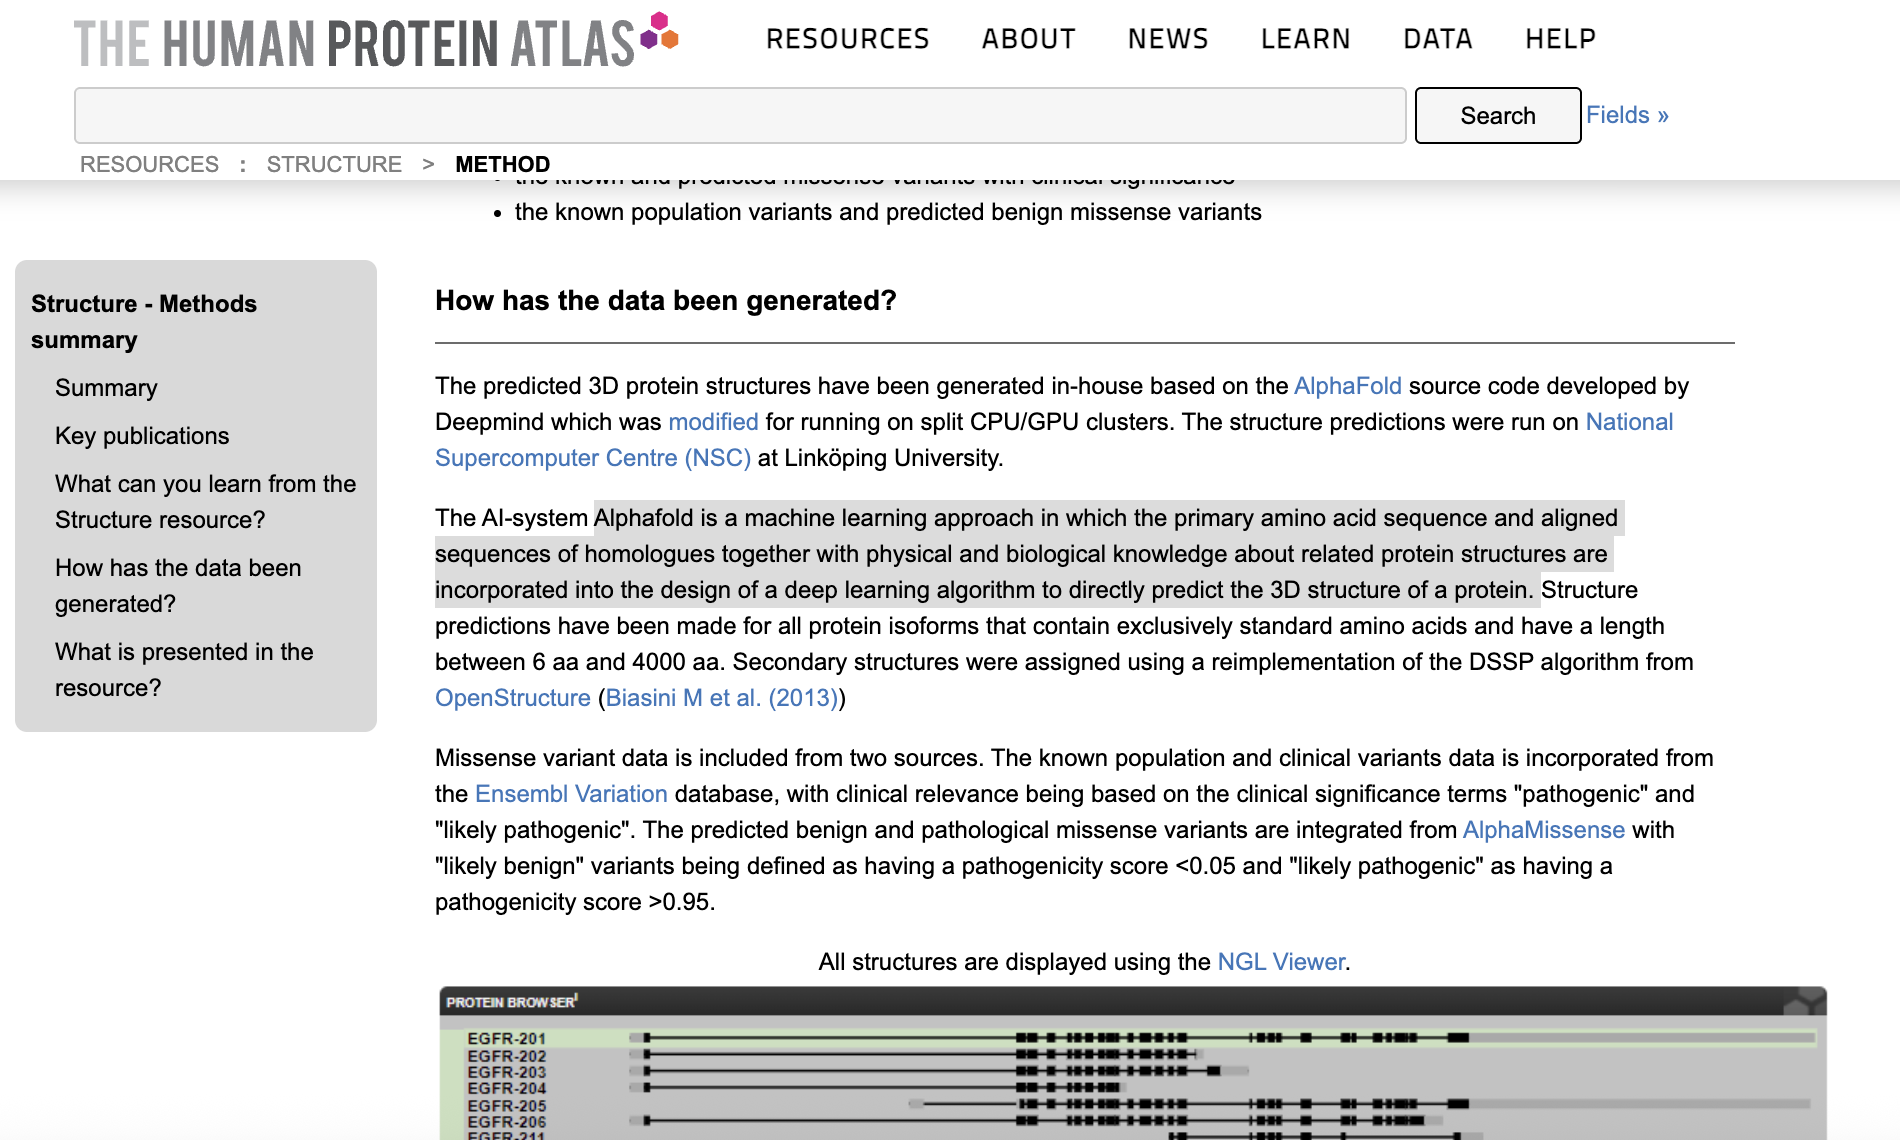

---
### **2.6 Few-Shot Prompting Classification:**

Few-shot prompting is a technique where a Large Language Model (LLM) is given a small number of labeled examples within a prompt to guide its classification. This allows the model to perform a new task with minimal data, avoiding the need for extensive fine-tuning.

In this lab, we will use the Gemini API to perform zero-shot, 1-shot, and 5-shot emotion classification:

*   **Zero-shot:** The model classifies text without any prior examples.
*   **1-shot:** The model is given one example for each emotion before classifying.
*   **5-shot:** The model is given five examples per emotion for better context.

To make our implementation robust and efficient, we are incorporating two key features:

1.  **Structured Output:** We provide the Gemini model with a specific output schema (`Emotions` class). This instructs the model to return *only* a valid emotion label (e.g., `joy`), which makes the output predictable and reliable, minimizing errors.
2.  **API Rate Handling:** The code includes a function to manage the requests-per-minute limit of the Gemini API.

We will test the model's performance on a small sample of 20 texts per emotion to ensure the process runs quickly. If the model provides an invalid response, the code will automatically retry the request until a valid classification is received.

**Prompt Structure:**
`System Instruction -> Task Description -> Examples (if not zero-shot) -> Text to Classify`


<span style="color:green">For the exercises in this section there is no need to re-run the cells, you can use the data that has been saved previously to the corresponding directory.</span>

In [ ]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'Predicted label',
           ylabel = 'True label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import enum
import os
from tqdm import tqdm
import json
import time
# Define the emotion labels
emotions = ['anger', 'fear', 'joy', 'sadness']
# Define the model to use for few-shot prompting

# Schema for the output, the type enum can be used to make a pool of options if what we want is to classify our text selecting only one of them
class Emotions(enum.StrEnum):
    ANGER = 'anger'
    FEAR = 'fear'
    JOY = 'joy'
    SADNESS = 'sadness'


# Function to handle the rate limits of gemini models
def handle_rate_limit(request_count, first_request_time, max_calls_per_min):
    current_time = time.time()

    # Initialize timer on the first request of a new window
    if request_count == 0:
        first_request_time = current_time

    request_count += 1

    # If the rate limit is reached
    if request_count > max_calls_per_min:
        elapsed_time = current_time - first_request_time
        if elapsed_time < 60:
            wait_time = 60 - elapsed_time
            print(f"Rate limit of {max_calls_per_min} requests per minute reached. Waiting for {wait_time:.2f} seconds.")
            time.sleep(wait_time)

        # Reset for the new window
        request_count = 1
        first_request_time = time.time()

    return request_count, first_request_time, max_calls_per_min

# Function to sample examples per emotion category
def sample_few_shots(df, emotions, num_samples=5):
    few_shot_examples = {}
    for emotion in emotions:
        few_shot_examples[emotion] = df[df['emotion'] == emotion].sample(n=num_samples, random_state=42)
    return few_shot_examples

# Function to build the prompt based on the number of examples (few-shot, 1-shot, zero-shot)
def build_prompt(examples, emotions, num_shots=5):
    classification_instructions = """
You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories:
"anger" | "fear" | "joy" | "sadness"
    """

    prompt = classification_instructions + "\n\n"

    if num_shots > 0:
        prompt += f"Examples: \n"
        for emotion in emotions:
            for _, row in examples[emotion].iterrows():
                prompt += f"Text: {row['text']}\nClass: {emotion}\n\n" #Show the examples in the same format it will be shown for the classification text
                if num_shots == 1:  # If 1-shot, break after the first example for each emotion
                    break
    return prompt

# Function to classify using the LLM with retry for incorrect responses
def classify_with_llm(test_text, prompt_base, system_prompt, classes, schema):
    response = None
    while not response or response not in classes:
        full_prompt = f"{prompt_base}\nClassification:\nText: {test_text}\nClass: " #The classification text will leave the emotion label to be filled in by the LLM
        try:
            result = prompt_gemini(input_prompt = [full_prompt], schema = schema, system_instruction = system_prompt)
            # print(f"result: {result} \n")
            # print(f"type: {type(result)}")
            if not result:
                # In case of giving empty responses with temperature 0.0, we set a higher temperature to seek for different responses
                result = prompt_gemini(input_prompt = [full_prompt], schema = schema, system_instruction = system_prompt, temperature=1.0)

            try:
                # If the result is in the correct format it can be parsed using json
                response = json.load(result)
            except:
                # In case it's not in a json friendly format
                # Deleting characters " and ' in case they appear in our response with the class of the text
                response = result.replace('"', '')
                response = response.replace("'", "")


        # except exceptions.ResourceExhausted as e:
        except Exception as e:
            print(f"Waiting to retry... Error: {e}")
            time.sleep(15)
            print(f"test_text: {test_text}")
            return classify_with_llm(test_text, prompt_base, system_prompt, classes, schema) # Retry the request


        if response not in classes:  # Retry if not a valid response
            print(f"Invalid response: {response}. Asking for reclassification.")
    return response

# Main function to run the experiment with the option for zero-shot, 1-shot, or 5-shot prompting
def run_experiment(df_train, df_test, num_test_samples=5, num_shots=5):
    # Sample examples for few-shot prompting based on num_shots
    if num_shots > 0:
        few_shot_examples = sample_few_shots(df_train, emotions, num_samples=num_shots)
        prompt_base = build_prompt(few_shot_examples, emotions, num_shots=num_shots)
    else:
        prompt_base = build_prompt(None, emotions, num_shots=0)  # Zero-shot has no examples

    # System prompt for our classification model:
    system_prompt = "You are an emotion classification model for text data. Do not give empty responses, classify according to the list of possible classes."

    # Prepare to classify the test set
    results_data = []

    print(prompt_base)
    # Sample 20 examples per emotion for the test set to classify
    test_samples = sample_few_shots(df_test, emotions, num_samples=num_test_samples)

    # Variables to handle rate limit of gemini
    request_count = 0
    max_calls_per_min = 15 # Gemini 2.5 Flash Lite has this maximum set in the documentation
    first_request_time = None

    # Classify 20 test examples (5 from each category) and save predictions
    for emotion in emotions:
        for _, test_row in tqdm(test_samples[emotion].iterrows(), desc=f"Processing samples for emotion: {emotion}...", total=num_test_samples):
            test_text = test_row['text']
            request_count, first_request_time, max_calls_per_min = handle_rate_limit(request_count, first_request_time, max_calls_per_min)  # Check and handle rate limit before each API call
            predicted_emotion = classify_with_llm(test_text = test_text, prompt_base = prompt_base, system_prompt = system_prompt, classes = emotions, schema = Emotions)
            # Append the results data:
            results_data.append({
                    'text': test_text,
                    'true_emotion': emotion,
                    'predicted_emotion': predicted_emotion
                })

    # Create dataframe to save the results data
    results_df = pd.DataFrame(results_data)

    # Extract just the true and predicted labels for metrics calculations
    true_labels = results_df['true_emotion']
    predictions = results_df['predicted_emotion']

    output_dir = "./DM2025-Lab2-Exercise/results/llm_classification_results"
    os.makedirs(output_dir, exist_ok=True)
    # Save the results
    filename = f"{output_dir}/results_samples_{num_test_samples}_shots_{num_shots}.csv"

    # Save the DataFrame to CSV
    results_df.to_csv(filename, index=False)
    print(f"\nResults saved to {filename}")

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Classification report
    print(classification_report(y_true=true_labels, y_pred=predictions))

    # Plot confusion matrix
    cm = confusion_matrix(y_true=true_labels, y_pred=predictions)
    my_tags = ['anger', 'fear', 'joy', 'sadness']
    plot_confusion_matrix(cm, classes=my_tags, title=f'Confusion matrix for classification with \n{num_shots}-shot prompting')

**Important: The next part should take around 16 minutes to finish running due to API Rate Limits**

**Note:** You might see an `429 RESOURCE_EXHAUSTED` error when running the following code all at once, this is because the `current API Rate Limit handling cannot reliably find out how many requests we have left per minute` from cell to cell, there is no Gemini feature created for it to get the information from their servers. So, `if you don't want to see the error you can just wait 1 minute` after one cell finished processing. But `even if there is an error showing it is fine`, internally in the code `there is a retry that happens every 15 seconds` until we finish processing our sampled data. `The lab is designed to never reach the total rate limit per day quota.`


You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories:
"anger" | "fear" | "joy" | "sadness"
    




Processing samples for emotion: anger...:  70%|███████   | 14/20 [00:11<00:04,  1.41it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 41.393348916s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions':

Processing samples for emotion: anger...:  75%|███████▌  | 15/20 [00:57<01:11, 14.35s/it]

Rate limit of 15 requests per minute reached. Waiting for 2.93 seconds.


Processing samples for emotion: fear...:  50%|█████     | 10/20 [00:06<00:07,  1.41it/s]

Rate limit of 15 requests per minute reached. Waiting for 49.71 seconds.


Processing samples for emotion: joy...:  25%|██▌       | 5/20 [00:03<00:10,  1.48it/s]

Rate limit of 15 requests per minute reached. Waiting for 49.49 seconds.


Processing samples for emotion: sadness...:   0%|          | 0/20 [00:00<?, ?it/s]

Rate limit of 15 requests per minute reached. Waiting for 47.66 seconds.


Processing samples for emotion: sadness...:  75%|███████▌  | 15/20 [00:58<00:03,  1.28it/s]

Rate limit of 15 requests per minute reached. Waiting for 48.73 seconds.


Processing samples for emotion: sadness...: 100%|██████████| 20/20 [01:51<00:00,  5.57s/it]



Results saved to ./DM2025-Lab2-Exercise/results/llm_classification_results/results_samples_20_shots_0.csv
Accuracy: 46.25%
              precision    recall  f1-score   support

       anger       0.39      0.60      0.47        20
        fear       0.83      0.25      0.38        20
         joy       0.52      0.85      0.64        20
     sadness       0.30      0.15      0.20        20

    accuracy                           0.46        80
   macro avg       0.51      0.46      0.42        80
weighted avg       0.51      0.46      0.42        80



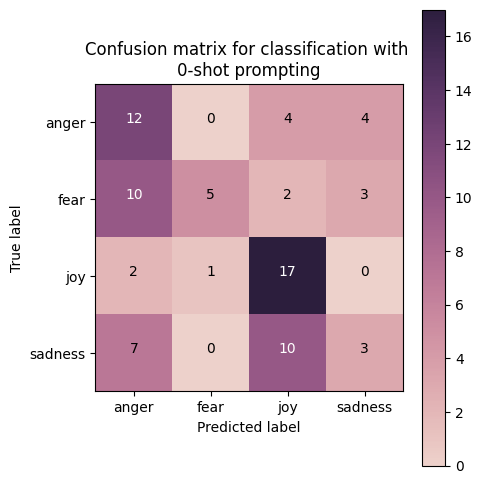

In [ ]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with zero-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=0)


You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories:
"anger" | "fear" | "joy" | "sadness"
    

Examples: 
Text: @BigBrother__USA she is just jealous and a cry baby! #bitter #gladsheisgone #crybaby
Class: anger

Text: mattmilne76 Thank you for letting us know!  Please do not hesitate to contact us in the future, if our assistance is needed. Thank you!
Class: fear

Text: 15 minutes of yoga to your breakfast routine will change your day #preparation #sunriseyoga #bodyawareness #health #yoga  #stretch
Class: joy

Text: @RossKemp great programme tonight #sad #upsetting #extremeworld
Class: sadness




Processing samples for emotion: anger...:  55%|█████▌    | 11/20 [00:08<00:07,  1.24it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 40.537509117s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions':

Processing samples for emotion: anger...:  75%|███████▌  | 15/20 [00:56<00:27,  5.46s/it]

Rate limit of 15 requests per minute reached. Waiting for 3.56 seconds.


Processing samples for emotion: fear...:  35%|███▌      | 7/20 [00:05<00:09,  1.33it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 38.689941629s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions':

Processing samples for emotion: fear...:  50%|█████     | 10/20 [00:53<01:15,  7.59s/it]

Rate limit of 15 requests per minute reached. Waiting for 2.62 seconds.


Processing samples for emotion: joy...:  15%|█▌        | 3/20 [00:02<00:13,  1.29it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 38.508142322s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions':

Processing samples for emotion: joy...:  25%|██▌       | 5/20 [00:49<03:03, 12.24s/it]

Rate limit of 15 requests per minute reached. Waiting for 3.06 seconds.


Processing samples for emotion: joy...:  95%|█████████▌| 19/20 [01:02<00:00,  1.00it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 37.906574573s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions':

Processing samples for emotion: sadness...:   0%|          | 0/20 [00:00<?, ?it/s]

Rate limit of 15 requests per minute reached. Waiting for 3.37 seconds.


Processing samples for emotion: sadness...:  75%|███████▌  | 15/20 [00:14<00:03,  1.36it/s]

Rate limit of 15 requests per minute reached. Waiting for 48.71 seconds.


Processing samples for emotion: sadness...: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]



Results saved to ./DM2025-Lab2-Exercise/results/llm_classification_results/results_samples_20_shots_1.csv
Accuracy: 53.75%
              precision    recall  f1-score   support

       anger       0.48      0.75      0.59        20
        fear       0.70      0.35      0.47        20
         joy       0.58      0.75      0.65        20
     sadness       0.46      0.30      0.36        20

    accuracy                           0.54        80
   macro avg       0.56      0.54      0.52        80
weighted avg       0.56      0.54      0.52        80



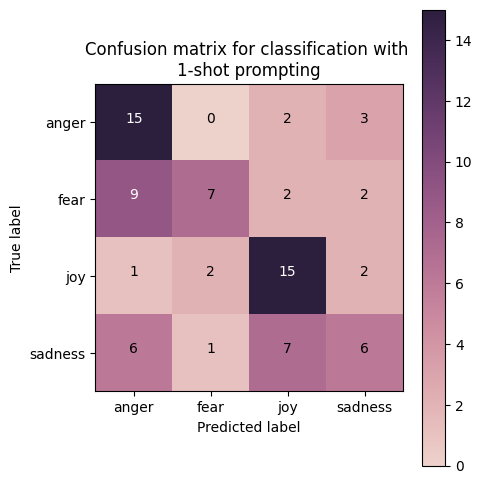

In [ ]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with 1-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=1)


You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories:
"anger" | "fear" | "joy" | "sadness"
    

Examples: 
Text: @BigBrother__USA she is just jealous and a cry baby! #bitter #gladsheisgone #crybaby
Class: anger

Text: @ParrishWalton @kjmgolf Also, our best assets on offense are our RB's and our WR's (longterm). Have to have an offense to utilize both.
Class: anger

Text: Prayers &amp; Protection to our brothers and sisters fighting in #Charlotte #rage #against #machines
Class: anger

Text: @ggreenwald Smh, remove ideologically bankrupt and opportunistic establishment now. They're burning all bridges and social contracts. #anger
Class: anger

Text: my wasp sting is so itchy
Class: anger

Text: mattmilne76 Thank you for letting us know!  Please do not hesitate to contact us in the future, if our assistance is needed. Thank you!
Class: fear

Text: Val is the type of woman you would dread bringing a donati

Processing samples for emotion: anger...:  55%|█████▌    | 11/20 [00:09<00:07,  1.15it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 34.675011202s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions':

Processing samples for emotion: anger...:  75%|███████▌  | 15/20 [00:57<00:27,  5.47s/it]

Rate limit of 15 requests per minute reached. Waiting for 2.21 seconds.


Processing samples for emotion: fear...:  35%|███▌      | 7/20 [00:05<00:08,  1.55it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 35.120463759s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions':

Processing samples for emotion: fear...:  50%|█████     | 10/20 [00:53<01:17,  7.73s/it]

Rate limit of 15 requests per minute reached. Waiting for 2.69 seconds.


Processing samples for emotion: joy...:  15%|█▌        | 3/20 [00:02<00:13,  1.27it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 33.328886992s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions':

Processing samples for emotion: joy...:  25%|██▌       | 5/20 [00:49<03:04, 12.32s/it]

Rate limit of 15 requests per minute reached. Waiting for 1.96 seconds.


Processing samples for emotion: joy...:  95%|█████████▌| 19/20 [01:03<00:00,  1.06it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 31.903521941s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions':

Processing samples for emotion: sadness...:   0%|          | 0/20 [00:00<?, ?it/s]

Rate limit of 15 requests per minute reached. Waiting for 1.64 seconds.


Processing samples for emotion: sadness...:  75%|███████▌  | 15/20 [00:12<00:03,  1.45it/s]

Rate limit of 15 requests per minute reached. Waiting for 49.06 seconds.


Processing samples for emotion: sadness...: 100%|██████████| 20/20 [01:06<00:00,  3.30s/it]



Results saved to ./DM2025-Lab2-Exercise/results/llm_classification_results/results_samples_20_shots_5.csv
Accuracy: 58.75%
              precision    recall  f1-score   support

       anger       0.54      0.65      0.59        20
        fear       0.70      0.35      0.47        20
         joy       0.70      0.80      0.74        20
     sadness       0.48      0.55      0.51        20

    accuracy                           0.59        80
   macro avg       0.60      0.59      0.58        80
weighted avg       0.60      0.59      0.58        80



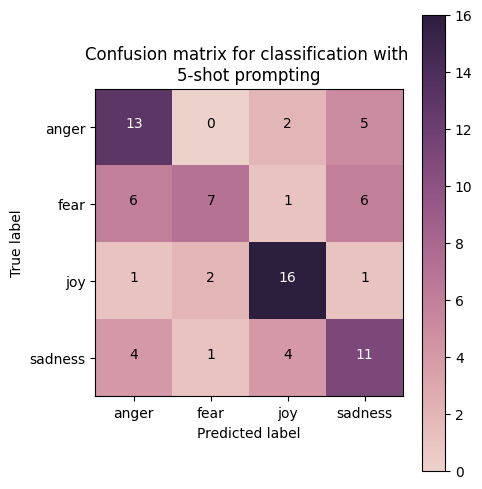

In [ ]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with 5-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=5)

---
##### **>>> Exercise 6 (Take home):**

Compare and discuss the overall results of the zero-shot, 1-shot and 5-shot classification.


ZERO-SHOT Results:
Accuracy: 46.25%

ONE-SHOT Results:
Accuracy: 53.75%

FIVE-SHOT Results:
Accuracy: 58.75%

Comparison:


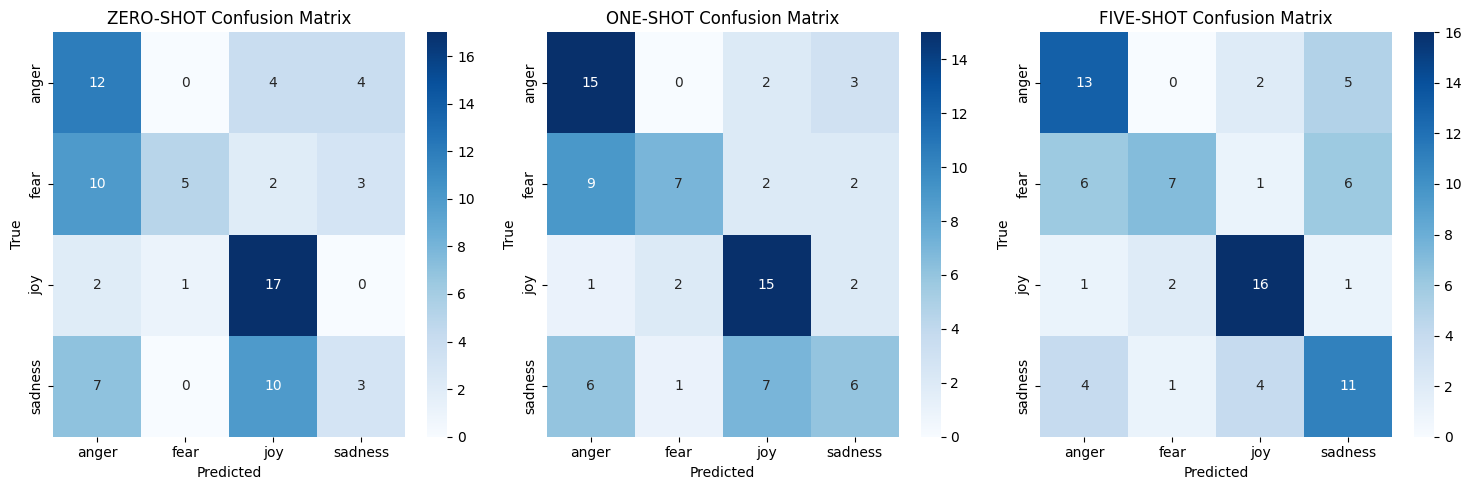

In [ ]:
# Answer here
# Compare zero-shot, 1-shot and 5-shot classification

# Get results
results_dir = "./DM2025-Lab2-Exercise/results/llm_classification_results/"
zero_shot_results = pd.read_csv(f"{results_dir}results_samples_20_shots_0.csv")
one_shot_results = pd.read_csv(f"{results_dir}results_samples_20_shots_1.csv")
five_shot_results = pd.read_csv(f"{results_dir}results_samples_20_shots_5.csv")


# Calculate metrics
def calculate_metrics(df,name):
    true_labels = df['true_emotion']
    predictions = df['predicted_emotion']
    accuracy = accuracy_score(true_labels, predictions)
    cm = confusion_matrix(true_labels, predictions, labels=['anger', 'fear', 'joy', 'sadness'])
    report = classification_report(true_labels, predictions, labels=['anger', 'fear', 'joy', 'sadness'], output_dict=True)
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return accuracy, cm, report

zero_metric = calculate_metrics(zero_shot_results, "ZERO-SHOT")
one_metric = calculate_metrics(one_shot_results, "ONE-SHOT")
five_metric = calculate_metrics(five_shot_results, "FIVE-SHOT")

# Plotly visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics = [zero_metric, one_metric, five_metric]
titles = ["ZERO-SHOT", "ONE-SHOT", "FIVE-SHOT"]
emotions = ['anger', 'fear', 'joy', 'sadness']

for ax, metric, title in zip(axes, metrics, titles):
    accuracy, cm, report = metric
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=emotions, yticklabels=emotions)
    ax.set_title(f"{title} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

print("\nComparison:")
plt.tight_layout()
plt.show()


**Exercise_6**


---


**Zero-Shot vs One-Shot vs Five-Shot Classification**


| Emotion  | Zero-Shot | One-Shot | Five-Shot | Change (0→5) |
|----------|-----------|----------|-----------|--------------|
| Anger    | 60%       | 50%      | 70%       | +10%         |
| Fear     | 30%       | 60%      | 55%       | +25%         |
| Joy      | 85%       | 85%      | 80%       | -5%          |
| Sadness  | 45%       | 55%      | 60%       | +15%         |


*   Confusion Matrices Analysis

|                             |                                                                                                                                                                                                            |
|-----------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Always Correct (51.25%)** | Suggests the model's understanding of the emotional content without needing examples                                                                                      |
| **Never Correct (28.75%)**  | Simply adding examples doesn't help when the text contains subtle emotional cues or mixed signals<br>Some texts may require domain knowledge or cultural context that examples alone cannot provide enough |
| **Improve (13.75%)**        | Few-shot examples assistant the model learn patterns and cues for these emotions<br>Examples help distinct subtle emotional expressions                                                                    |
| **Worse (2.50%)**           | Example patterns don't generalize to these edge cases<br>The chosen specific examples might be introduced bias or confusion                                                                                |
| **Inconsistent (3.75%)**    | May indicate **borderline cases** where the small variations may have a significant impact                                                                                                                     |


*   Class Performance Summary

| **Classes** | **Performance**                                          | **Summary**                                                                              |
|-------------|----------------------------------------------------------|------------------------------------------------------------------------------------------|
| **Anger**   | Appears across multiple categories                       | Can be confused with fear                                                                |
| **Fear**    | Frequently in both "Never Correct" (8) and "Improve" (5) | Rely on learning from examples but still difficulty distinct in cases                    |
| **Sadness** | Highly represented in "Never Correct" (7)                | May share features with other negative emotions, making distinction difficult |
| **Joy**     | Least represented in "Never Correct" (3)                 | Generally easier to classify, possibly due to more distinctive patterns                  |


---
##### **>>> Exercise 7 (Take home):**

**Case Study:** Check the results' files inside the `results/llm_classification_results` directory and find cases where the **text classification improves with more examples** (pred emotion is right with examples), **cases where it does not improve** (pred emotion always wrong) and **cases where the classification got worse with more examples** (pred emotion goes from right to wrong with examples). For this you need to load the results with pandas and handle the data using its dataframe functions. Discuss about the findings.

Always Correct: 34(42.50%)
Never Correct: 29(36.25%)
Improve: 12(15.00%)
Inconsistent: 3(3.75%)
Worse: 2(2.50%)


Improves(12):
true_emotion
sadness    8
anger      2
fear       2
Name: count, dtype: int64
Text:@fluffysoftlouis no no. I insist that you give me your best insult first
True:anger
ZERO-SHOT:joy→FIVE-SHOT:anger


Never Correct(29):
true_emotion
fear       12
sadness     9
anger       5
joy         3
Name: count, dtype: int64
Text:Having a baby born too soon is #lifechanging 6 years on and it feels like only yesterday #sad #happy #angry #emotionalrollercoaster
True:anger
All wrong:
ZERO-SHOT:sadness|ONE-SHOT:sadness|FIVE-SHOT:sadness


Worse(2):
true_emotion
anger    1
joy      1
Name: count, dtype: int64
Text:@IllinoisLoyalty that Rutgers game was an abomination. An affront to God and man. We must never speak of it again.
True:anger
ZERO-SHOT:anger(CORRECT)→FIVE-SHOT:sadness(WRONG)


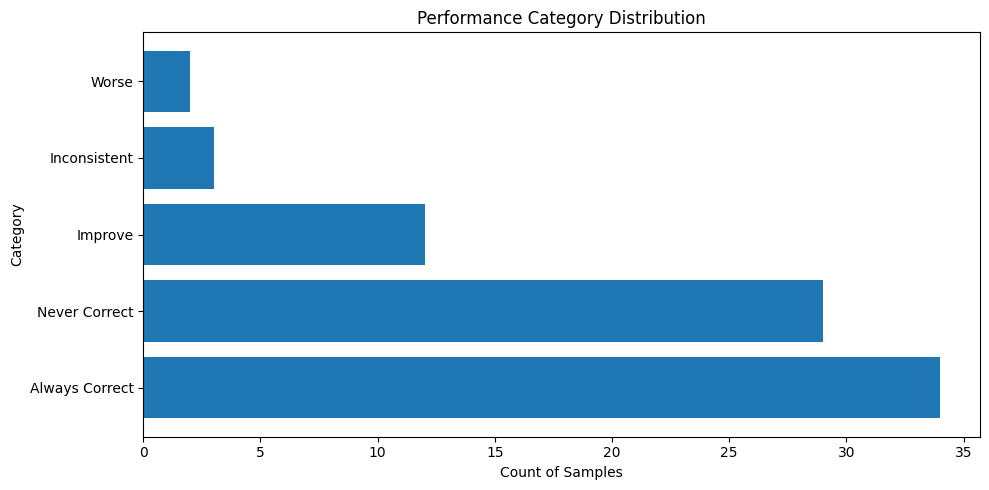

In [ ]:
# Answer here
# Classfication performance patterns
# Improve/ Never improve/ Worse with examples

# Load results
results_dir = "./DM2025-Lab2-Exercise/results/llm_classification_results/"
zero_shot_results = pd.read_csv(f"{results_dir}results_samples_20_shots_0.csv")
one_shot_results = pd.read_csv(f"{results_dir}results_samples_20_shots_1.csv")
five_shot_results = pd.read_csv(f"{results_dir}results_samples_20_shots_5.csv")

for df in [zero_shot_results, one_shot_results, five_shot_results]:
    df['sample_id'] = range(len(df))

merged_df = zero_shot_results[['sample_id', 'text', 'true_emotion', 'predicted_emotion']].copy()
merged_df.columns = ['sample_id', 'text', 'true_emotion', 'predicted_emotion_zero_shot']
merged_df = merged_df.merge(one_shot_results[['sample_id', 'predicted_emotion']].rename(columns={'predicted_emotion':'predicted_emotion_one_shot'}), on='sample_id', how='left')
merged_df = merged_df.merge(five_shot_results[['sample_id', 'predicted_emotion']].rename(columns={'predicted_emotion':'predicted_emotion_five_shot'}), on='sample_id', how='left')

# Categorize performance
def categorize(row):
    C0 = row['predicted_emotion_zero_shot'] == row['true_emotion']
    C1 = row['predicted_emotion_one_shot'] == row['true_emotion']
    C5 = row['predicted_emotion_five_shot'] == row['true_emotion']

    if not C0 and C5:
        return 'Improve'
    elif not C0 and not C1 and not C5:
        return 'Never Correct'
    elif C0 and not C5:
        return 'Worse'
    elif C0 and C1 and C5:
        return 'Always Correct'
    else:
        return 'Inconsistent'

merged_df['category'] = merged_df.apply(categorize, axis=1)

# Counting
category_counts = merged_df['category'].value_counts()
for cat, count in category_counts.items():
    pct = (count / len(merged_df)) * 100
    print(f"{cat}: {count}({pct:.2f}%)")

# Analze categories
improve = merged_df[merged_df['category'] == 'Improve']
never_correct = merged_df[merged_df['category'] == 'Never Correct']
worse = merged_df[merged_df['category'] == 'Worse']
always_correct = merged_df[merged_df['category'] == 'Always Correct']
inconsistent = merged_df[merged_df['category'] == 'Inconsistent']

print(f"\n\nImproves({len(improve)}):")
if len(improve) > 0:
    print(improve['true_emotion'].value_counts())
    sample = improve.iloc[0]
    print(f"Text:{sample['text']}")
    print(f"True:{sample['true_emotion']}")
    print(f"ZERO-SHOT:{sample['predicted_emotion_zero_shot']}→FIVE-SHOT:{sample['predicted_emotion_five_shot']}")

print(f"\n\nNever Correct({len(never_correct)}):")
if len(never_correct) > 0:
    print(never_correct['true_emotion'].value_counts())
    sample = never_correct.iloc[0]
    print(f"Text:{sample['text']}")
    print(f"True:{sample['true_emotion']}")
    print(f"All wrong:")
    print(f"ZERO-SHOT:{sample['predicted_emotion_zero_shot']}|ONE-SHOT:{sample['predicted_emotion_one_shot']}|FIVE-SHOT:{sample['predicted_emotion_five_shot']}")

print(f"\n\nWorse({len(worse)}):")
if len(worse) > 0:
    print(worse['true_emotion'].value_counts())
    sample = worse.iloc[0]
    print(f"Text:{sample['text']}")
    print(f"True:{sample['true_emotion']}")
    print(f"ZERO-SHOT:{sample['predicted_emotion_zero_shot']}(CORRECT)→FIVE-SHOT:{sample['predicted_emotion_five_shot']}(WRONG)")

# Ploty visualization

fig,ax = plt.subplots(figsize=(10,5))
ax.barh(range(len(category_counts)), category_counts.values)
ax.set_yticks(range(len(category_counts)))
ax.set_yticklabels(category_counts.index)
ax.set_xlabel('Count of Samples')
ax.set_ylabel('Category')
ax.set_title('Performance Category Distribution')
plt.tight_layout()
plt.show()

**Exercise_7**


---


**The analysis of LLM classification performance across different numbers of examples (0-shot, 1-shot, 5-shot)**


*   **Findings:**




|                             |                                                                                                                                                                                                            |
|-----------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Always Correct (51.25%)** | More than half of the test cases suggests the model's understanding of the emotional content without needing examples                                                                                      |
| **Never Correct (28.75%)**  | Simply adding examples doesn't help when the text contains subtle emotional cues or mixed signals<br>Some texts may require domain knowledge or cultural context that examples alone cannot provide enough |
| **Improve (13.75%)**        | Few-shot examples assistant the model learn patterns and cues for these emotions<br>Examples help distinct subtle emotional expressions                                                                    |
| **Worse (2.50%)**           | Example patterns don't generalize to these edge cases<br>The chosen specific examples might be introduced bias or confusion                                                                                |
| **Inconsistent (3.75%)**    | May indicate borderline cases where the small variations may have a significant impact                                                                                                                     |


*   **Emotion-Specific Patterns:**

|             |                                                          |                                                                                          |
|-------------|----------------------------------------------------------|------------------------------------------------------------------------------------------|
| **Fear**    | Frequently in both "Never Correct" (8) and "Improve" (5) | Rely on learning from examples but still difficulty distinct in cases                    |
| **Sadness** | Highly represented in "Never Correct" (7)                | May share linguistic features with other negative emotions, making distinction difficult |
| **Anger**   | Appears across multiple categories                       | Can be confused with fear                                                                |
| **Joy**     | Least represented in "Never Correct" (3)                 | Generally easier to classify, possibly due to more distinctive patterns                  |

---
### **2.7 Extra LLM Related Materials:**
So this will be it for the lab, but here are some extra materials if you would like to explore:

- **How to use OpenAI ChatGPT model's API (Not Free API):** [Basics Video](https://www.youtube.com/watch?v=e9P7FLi5Zy8), [Basics GitHub](https://github.com/gkamradt/langchain-tutorials/blob/main/chatapi/ChatAPI%20%2B%20LangChain%20Basics.ipynb), [RAG's Basics Video](https://www.youtube.com/watch?v=9AXP7tCI9PI&t=300s), [RAG's Basics GitHub](https://github.com/techleadhd/chatgpt-retrieval)

- **Advanced topic - QLoRA (Quantized Low-Rank Adapter):** QLoRA is a method used to make fine-tuning large language models more efficient. It works by adding a small, trainable part (LoRA) to a pre-trained model, while keeping the rest of the model frozen. At the same time, it reduces the size of the model’s data using a process called quantization, which makes the model require less memory. This allows you to fine-tune large models without needing as much computational power, making it easier to adapt models for specific tasks. Materials: [Paper GitHub](https://github.com/artidoro/qlora?tab=readme-ov-file), [Llama 3 Application Video](https://www.youtube.com/watch?v=YJNbgusTSF0&t=512s),[Llama 3 Application GitHub](https://github.com/adidror005/youtube-videos/blob/main/LLAMA_3_Fine_Tuning_for_Sequence_Classification_Actual_Video.ipynb)

- **How to Fine-tune and run local LLMs with the `unsloth` library:** [unsloth tutorials](https://docs.unsloth.ai/models/tutorials-how-to-fine-tune-and-run-llms)

- **Google's Agent Development Kit Documentation:** [ADK](https://google.github.io/adk-docs/)

- **Build AI agents with LangGraph:** [LangGraph Documentation](https://langchain-ai.github.io/langgraph/concepts/why-langgraph/)

---